# FlexzBoost on cosmoDC2 French vs Sam

<span style="font-size:22px;"> Author: Iago Lopes Soares Dias<br>
Email: iagolops2012@gmail.com</span>


<span style="font-size:20px;"> The objective of this notebook is to evaluate FlexzBoost on simulated data of LSST, more specifically cosmo DC2 data that came from PZ French WG (BPZ training set) and from Sam (cosmoDC2_10_year_error_estimate). </span>
<span style="font-size:20px;"> If you just want to check the results, you can skip to "Results" section.</span>

## Importing packages

In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io
import qp
import sys


from matplotlib import gridspec
import seaborn as sns
from qp.metrics.pit import PIT
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp


from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
from rail.evaluation.metrics.base import MetricEvaluator
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle, Hdf5Handle
from rail.core.util_stages import ColumnMapper, TableConverter
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer
from rail.estimation.algos.var_inf import VarInfStackSummarizer
from rail.evaluation.metrics.cdeloss import *
from qp.metrics.pit import PIT

import warnings
warnings.filterwarnings("ignore")

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Selecting the data and analysing

## Functions to analyze

### plot_errors

In [3]:
def plot_errors(catalog):
    bands = ['u', 'g', 'r', 'i', 'z', 'y']
    j=1
    plt.figure(figsize=[9,13])
    for i, band in enumerate(bands):

        plt.subplot(3,2,j) 
        mag = np.array(catalog[f'mag_{band}_lsst'])
        err = np.array(catalog[f'mag_err_{band}_lsst'])
        sn = 1/(10**(0.4*err)-1)
        plt.hexbin(mag,sn , None, mincnt=1, cmap='inferno', gridsize=[400,200], bins='log')
        cbar = plt.colorbar()
        plt.ylabel("S/R ", fontsize=13)
        plt.xlabel("mag "+band, fontsize=13)
        plt.ylim(0,100)
        plt.xlim(20,30)
        plt.axhline(10, color= 'red')
        plt.grid(True)
        j+=1
        plt.tight_layout()

### mag_histogram

In [4]:
def mag_histogram(catalog, title='DP0.2'):
    
    bands = ['u','g', 'r', 'i', 'z','y']
    colors = ['blue', 'green', 'orange','red','purple','gray']
    plt.figure(figsize=(9,13))
    bins = np.linspace(9, 37, 57)
    j=1
    for i, (band, color) in enumerate(zip(bands,colors)):
        plt.subplot(3,2,j)
        plt.hist(catalog[f'mag_{band}_lsst'], histtype='stepfilled', bins=bins, label=f'{band} band', alpha = 0.5,
                 edgecolor = "black", color = color)
        #plt.xlim(16,27)
        plt.yscale('log')
        plt.xlabel('mag',fontsize=13)
        plt.ylabel('counts',fontsize=13)
        plt.legend(loc=2)
        plt.grid(True)
        j+=1
    plt.suptitle(title,fontsize=16)
    plt.show()


### mag_color

In [5]:
def mag_color(catalog,title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    mag_diff = {}
    plt.figure(figsize=(9,13))
    i=1
    for band,_band in zip(bands, bands[1::]):
        plt.subplot(3,2,i)
        i+=1
        mag_diff_v = catalog[f'mag_{band}_lsst']-catalog[f'mag_{_band}_lsst']
        mag_v = catalog[f'mag_{band}_lsst'] 
                   
        plt.hexbin(mag_v, mag_diff_v, None, mincnt=1, cmap='Reds', gridsize=[400,200], bins='log')

        plt.xlabel("mag "+band,fontsize=13)
        plt.ylabel(f"{band}-{_band}",fontsize=13)
        #plt.legend()
        plt.xlim(16,32)
        plt.ylim(-2,5)
        plt.grid(True)
        plt.suptitle(title,fontsize=16)
        plt.tight_layout()
    plt.show()

### color_color

In [6]:
def cor_cor(catalog,title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        plt.hist2d(past_color-color,color-next_color, bins = 100, cmap='turbo' )
        plt.ylabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.xlabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        #plt.axvline(0)
        #plt.axhline(0)
        plt.suptitle(title,fontsize=16)
    plt.show()

In [7]:
def color_color(catalog,title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, None, mincnt=1, cmap='turbo', gridsize=[400,400], bins='log')
        plt.ylabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.xlabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar()
        plt.xlim(-1,3)
        plt.ylim(-1,3)
        plt.suptitle(title,fontsize=16)
    plt.show()

In [8]:
def color_color_red(catalog,xlim=[-1,3],ylim=[-1,3],title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, C=catalog['redshift'], mincnt=1, cmap='turbo', gridsize=[400,400])
        plt.ylabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.xlabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar(label='redshift')
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
        plt.suptitle(title,fontsize=16)
    plt.show()

## Reading data

The data used here comes from the DESC PZ Working Group. We don't now if the reddening was removed.

In [9]:
french = pd.read_csv('/home/iago/ic_cosmo/samples/sample_cosmodc2_w10year_errors.dat', sep =' ')

french.drop('dec',axis=1,inplace=True)



In [10]:
sam_test =  tables_io.read('/home/iago/ic_cosmo/samples/cosmodc2_460k_positions_i26_5_testset.hdf5')['photometry']
sam_train = tables_io.read('/home/iago/ic_cosmo/samples/cosmodc2_halfhealpix_positions_i26_5_training.hdf5')['photometry']

In [11]:
columns_map = {
    "#id": "redshift",
    "ra": "dec", 
    "sz": "ra",
    "u": "mag_u_lsst",
    "uerr": "mag_err_u_lsst",
    "g": "mag_g_lsst",
    "gerr": "mag_err_g_lsst",
    "r": "mag_r_lsst",
    "rerr": "mag_err_r_lsst",
    "i": "mag_i_lsst",
    "ierr": "mag_err_i_lsst",
    "y": "mag_y_lsst",
    "yerr": "mag_err_y_lsst",
    "z": "mag_z_lsst",
    "zerr": "mag_err_z_lsst",
    "galid": "galid"
}
french = french.rename(columns=columns_map)


In [12]:
sam_train = pd.DataFrame(sam_train)
sam_test = pd.DataFrame(sam_test)

In [13]:
french

redshift         ra        dec  mag_u_lsst  mag_err_u_lsst  \
0           0.0220  62.584977 -40.334110     17.6159          0.0050   
100         0.0489  62.737951 -40.310046     19.3351          0.0051   
200         0.0258  61.679292 -41.217925     23.0562          0.0144   
300         0.0292  62.836708 -40.058639     23.7464          0.0251   
400         0.0336  62.349167 -40.069310     23.1186          0.0151   
...            ...        ...        ...         ...             ...   
10409900    2.8531  65.820556 -37.911725     27.6754          0.8820   
10410000    2.8760  67.040719 -38.408924     28.2485          1.4946   
10410100    2.9215  66.338044 -38.558236     26.7672          0.3827   
10410200    3.0305  66.287684 -38.883792     29.0782          3.2079   
10410300    2.9476  65.884390 -39.271043     25.8659          0.1675   

          mag_g_lsst  mag_err_g_lsst  mag_r_lsst  mag_err_r_lsst  mag_i_lsst  \
0            16.3943          0.0050     15.9683          0.0050     15.7529   
100          18.0216          0.0050     17.4491          0.0050     17.1498   
200          21.9222          0.0053     21.5337          0.0051     21.3164   
300          22.4624          0.0057     21.8373          0.0051     21.5111   
400          22.0724          0.0054     21.7829          0.0051     21.6102   
...              ...             ...         ...             ...         ...   
10409900     25.8391          0.0488     25.4753          0.0307     25.2173   
10410000     25.4134          0.0334     25.0840          0.0217     25.1027   
10410100     25.0215          0.0237     24.7763          0.0167     24.8933   
10410200     25.3102          0.0305     25.1340          0.0227     25.2163   
10410300     24.7771          0.0193     24.5671          0.0141     24.5893   

          mag_err_i_lsst  mag_z_lsst  mag_err_z_lsst  mag_y_lsst  \
0                 0.0050     15.6386          0.0050     15.5775   
100               0.0050     16.9570          0.0050     16.8299   
200               0.0052     21.2373          0.0055     21.1947   
300               0.0053     21.3566          0.0056     21.2626   
400               0.0053     21.5308          0.0059     21.5019   
...                  ...         ...             ...         ...   
10409900          0.0455     25.1953          0.0900     25.0288   
10410000          0.0410     25.0662          0.0800     25.3066   
10410100          0.0340     24.8028          0.0628     24.8250   
10410200          0.0454     25.4343          0.1121     25.5566   
10410300          0.0259     24.7606          0.0604     24.6250   

          mag_err_y_lsst       galid      Av  
0                 0.0050 -2147483648  0.0655  
100               0.0050 -2147483648  0.0980  
200               0.0085 -2147483648  0.1502  
300               0.0089 -2147483648  0.2221  
400               0.0105 -2147483648  0.1636  
...                  ...         ...     ...  
10409900          0.2364 -2147483648  0.0000  
10410000          0.3053 -2147483648  0.2084  
10410100          0.1960 -2147483648  0.1290  
10410200          0.3843 -2147483648  0.0070  
10410300          0.1630 -2147483648  1.2032  

[104104 rows x 17 columns]

In [14]:
sam_train

dec        gr    gr_err           id        iz    iz_err  \
0      -26.796273  0.435994  0.007072   1250000000  0.164345  0.007072   
1      -25.434209  0.439835  0.012676   1250000225  0.090141  0.014104   
2      -26.159795  0.330523  0.008828   1250000450  0.039524  0.009960   
3      -25.859686  0.427570  0.009876   1250000675  0.102930  0.010689   
4      -25.678309  0.686884  0.007932   1250000900  0.181633  0.007676   
...           ...       ...       ...          ...       ...       ...   
467511 -44.663421  0.113300  0.158715  12082698485  0.019361  0.245783   
467512 -45.265560  0.611593  0.197180  12082702112  0.185627  0.207731   
467513 -45.770126  0.038696  0.197801  12082705368 -0.068195  0.394990   
467514 -46.010853  0.184448  0.135202  12082813708 -0.298508  0.308424   
467515 -45.925621  0.166254  0.227262  12083087639  0.390142  0.297576   

        mag_err_g_lsst  mag_err_i_lsst  mag_err_r_lsst  mag_err_u_lsst  ...  \
0             0.005001        0.005000        0.005000        0.005017  ...   
1             0.010262        0.008135        0.007441        0.131178  ...   
2             0.006645        0.006154        0.005813        0.056329  ...   
3             0.007698        0.006572        0.006186        0.073198  ...   
4             0.005943        0.005278        0.005254        0.052234  ...   
...                ...             ...             ...             ...  ...   
467511        0.122208        0.122385        0.101269       26.620825  ...   
467512        0.174618        0.115517        0.091588       26.620825  ...   
467513        0.147949        0.184823        0.131287        1.218981  ...   
467514        0.106793        0.121504        0.082916       26.620825  ...   
467515        0.178392        0.186907        0.140799        1.357517  ...   

        mag_y_lsst  mag_z_lsst         ra  redshift        ri    ri_err  \
0        15.137871   15.244094  50.747302  0.014800  0.259352  0.007071   
1        22.663742   22.714552  50.313925  0.048879  0.233574  0.011025   
2        22.090605   22.109261  50.438110  0.047392  0.184605  0.008465   
3        22.151592   22.242300  50.441530  0.072630  0.224634  0.009025   
4        20.985334   21.085735  51.728657  0.066845  0.348433  0.007447   
...            ...         ...        ...       ...       ...       ...   
467511   26.366076   26.015394  73.227653  2.939646  0.197647  0.158850   
467512   25.207281   25.786221  73.669118  3.063382  0.150948  0.147420   
467513   27.121641   26.551600  73.994854  2.998359  0.031853  0.226707   
467514   26.295479   26.325401  74.402373  3.032414 -0.012690  0.147100   
467515   26.625195   26.105455  73.745738  3.016731  0.095812  0.234006   

               ug     ug_err        zy    zy_err  
0        0.958424   0.007083  0.106223  0.007072  
1        1.240664   0.131579  0.050810  0.025856  
2        1.125933   0.056719  0.018656  0.016316  
3        1.081667   0.073602  0.090708  0.017235  
4        1.403452   0.052571  0.100401  0.008988  
...           ...        ...       ...       ...  
467511  72.654297  26.621105 -0.350681  0.710911  
467512  72.265610  26.621399  0.578939  0.290347  
467513   0.590992   1.227926 -0.570042  1.404010  
467514  72.801346  26.621040  0.029922  0.695884  
467515   0.504219   1.369188 -0.519739  0.891538  

[467516 rows x 26 columns]

In [15]:
sam_test

dec        gr    gr_err           id        iz    iz_err  \
0      -25.221269  0.670420  0.007072   1312500000  0.193890  0.007071   
1      -25.862402  0.315699  0.007944   1312500225  0.077675  0.008477   
2      -26.246954  0.174147  0.033231   1312500450  0.122187  0.047875   
3      -25.825304  0.275715  0.013911   1312500675  0.048395  0.018623   
4      -26.100693  0.434650  0.056377   1312500900  0.127439  0.064814   
...           ...       ...       ...          ...       ...       ...   
459879 -44.468859  0.321768  0.152475  12020227767 -0.303936  0.248236   
459880 -45.141045  0.403038  0.175803  12020231248 -0.284409  0.463913   
459881 -44.817129  0.745779  0.215683  12020282535 -0.130091  0.372210   
459882 -44.907943  0.136423  0.204941  12020553074 -1.089359  0.850464   
459883 -44.141793  0.224892  0.182998  12020819041  0.154181  0.321155   

        mag_err_g_lsst  mag_err_i_lsst  mag_err_r_lsst  mag_err_u_lsst  ...  \
0             0.005001        0.005000        0.005000        0.005026  ...   
1             0.005824        0.005575        0.005403        0.033321  ...   
2             0.026059        0.025786        0.020620        0.306728  ...   
3             0.010965        0.010116        0.008561        0.123833  ...   
4             0.047869        0.034883        0.029781        0.498633  ...   
...                ...             ...             ...             ...  ...   
459879        0.125821        0.097429        0.086126       20.088198  ...   
459880        0.148396        0.184665        0.094263        0.785022  ...   
459881        0.195672        0.166510        0.090727        0.828054  ...   
459882        0.159157        0.172251        0.129111        2.759413  ...   
459883        0.146542        0.174971        0.109607        0.716050  ...   

        mag_y_lsst  mag_z_lsst         ra  redshift        ri    ri_err  \
0        14.687290   14.804871  53.893617  0.015425  0.354918  0.007071   
1        21.592501   21.638060  53.540916  0.030609  0.185198  0.007763   
2        24.262041   24.195457  54.011931  0.045475  0.147116  0.033017   
3        23.041840   23.107073  52.374587  0.065590  0.142187  0.013252   
4        24.545084   24.529957  54.216520  0.065404  0.227051  0.045866   
...            ...         ...        ...       ...       ...       ...   
459879   26.730179   26.090155  70.699596  2.999858  0.269466  0.130039   
459880   26.409260   26.766876  69.746133  2.991169 -0.328266  0.207332   
459881   26.040960   26.499992  70.226688  2.994675 -0.257412  0.189624   
459882   26.551975   27.496140  70.959177  2.969296  0.090273  0.215267   
459883   28.038321   26.269642  69.640628  2.982220 -0.105167  0.206467   

              ug     ug_err        zy    zy_err  
0       1.467150   0.007090  0.117580  0.007072  
1       0.985800   0.033827  0.045559  0.011785  
2       1.005987   0.307833 -0.066584  0.105942  
3       1.082401   0.124318  0.065233  0.035906  
4       0.854380   0.500925 -0.015127  0.138261  
...          ...        ...       ...       ...  
459879  3.810438  20.088593 -0.640024  0.975423  
459880  0.109570   0.798925  0.357616  0.824104  
459881 -0.133469   0.850859  0.459032  0.602986  
459882  1.398870   2.763999  0.944164  1.158167  
459883  0.023319   0.730892 -1.768679  3.174796  

[459884 rows x 26 columns]

In [16]:
catalog = pd.concat([french,sam_test,sam_train],ignore_index=True)
sam = pd.concat([sam_test,sam_train])

In [17]:
catalog

redshift         ra        dec  mag_u_lsst  mag_err_u_lsst  \
0        0.022000  62.584977 -40.334110   17.615900        0.005000   
1        0.048900  62.737951 -40.310046   19.335100        0.005100   
2        0.025800  61.679292 -41.217925   23.056200        0.014400   
3        0.029200  62.836708 -40.058639   23.746400        0.025100   
4        0.033600  62.349167 -40.069310   23.118600        0.015100   
...           ...        ...        ...         ...             ...   
1031499  2.939646  73.227653 -44.663421   99.000000       26.620825   
1031500  3.063382  73.669118 -45.265560   99.000000       26.620825   
1031501  2.998359  73.994854 -45.770126   27.144945        1.218981   
1031502  3.032414  74.402373 -46.010853   99.000000       26.620825   
1031503  3.016731  73.745738 -45.925621   27.261883        1.357517   

         mag_g_lsst  mag_err_g_lsst  mag_r_lsst  mag_err_r_lsst  mag_i_lsst  \
0         16.394300        0.005000   15.968300        0.005000   15.752900   
1         18.021600        0.005000   17.449100        0.005000   17.149800   
2         21.922200        0.005300   21.533700        0.005100   21.316400   
3         22.462400        0.005700   21.837300        0.005100   21.511100   
4         22.072400        0.005400   21.782900        0.005100   21.610200   
...             ...             ...         ...             ...         ...   
1031499   26.345703        0.122208   26.232403        0.101269   26.034756   
1031500   26.734388        0.174618   26.122795        0.091588   25.971848   
1031501   26.553953        0.147949   26.515257        0.131287   26.483404   
1031502   26.198652        0.106793   26.014204        0.082916   26.026894   
1031503   26.757664        0.178392   26.591410        0.140799   26.495598   

         ...    gr_err            id        iz    iz_err        ri    ri_err  \
0        ...       NaN           NaN       NaN       NaN       NaN       NaN   
1        ...       NaN           NaN       NaN       NaN       NaN       NaN   
2        ...       NaN           NaN       NaN       NaN       NaN       NaN   
3        ...       NaN           NaN       NaN       NaN       NaN       NaN   
4        ...       NaN           NaN       NaN       NaN       NaN       NaN   
...      ...       ...           ...       ...       ...       ...       ...   
1031499  ...  0.158715  1.208270e+10  0.019361  0.245783  0.197647  0.158850   
1031500  ...  0.197180  1.208270e+10  0.185627  0.207731  0.150948  0.147420   
1031501  ...  0.197801  1.208271e+10 -0.068195  0.394990  0.031853  0.226707   
1031502  ...  0.135202  1.208281e+10 -0.298508  0.308424 -0.012690  0.147100   
1031503  ...  0.227262  1.208309e+10  0.390142  0.297576  0.095812  0.234006   

                ug     ug_err        zy    zy_err  
0              NaN        NaN       NaN       NaN  
1              NaN        NaN       NaN       NaN  
2              NaN        NaN       NaN       NaN  
3              NaN        NaN       NaN       NaN  
4              NaN        NaN       NaN       NaN  
...            ...        ...       ...       ...  
1031499  72.654297  26.621105 -0.350681  0.710911  
1031500  72.265610  26.621399  0.578939  0.290347  
1031501   0.590992   1.227926 -0.570042  1.404010  
1031502  72.801346  26.621040  0.029922  0.695884  
1031503   0.504219   1.369188 -0.519739  0.891538  

[1031504 rows x 28 columns]

### Removing 99 values

In [18]:
bands = ['u','g','r','i','z','y']

for band in bands:
    # 99 values
    sam_train = sam_train[sam_train[f'mag_{band}_lsst']<99]
    sam_test = sam_test[sam_test[f'mag_{band}_lsst']<99]
    french = french[french[f'mag_{band}_lsst']<99]
    sam = sam[sam[f'mag_{band}_lsst']<99]
    

## Plotting the data and analysing

### Plot error

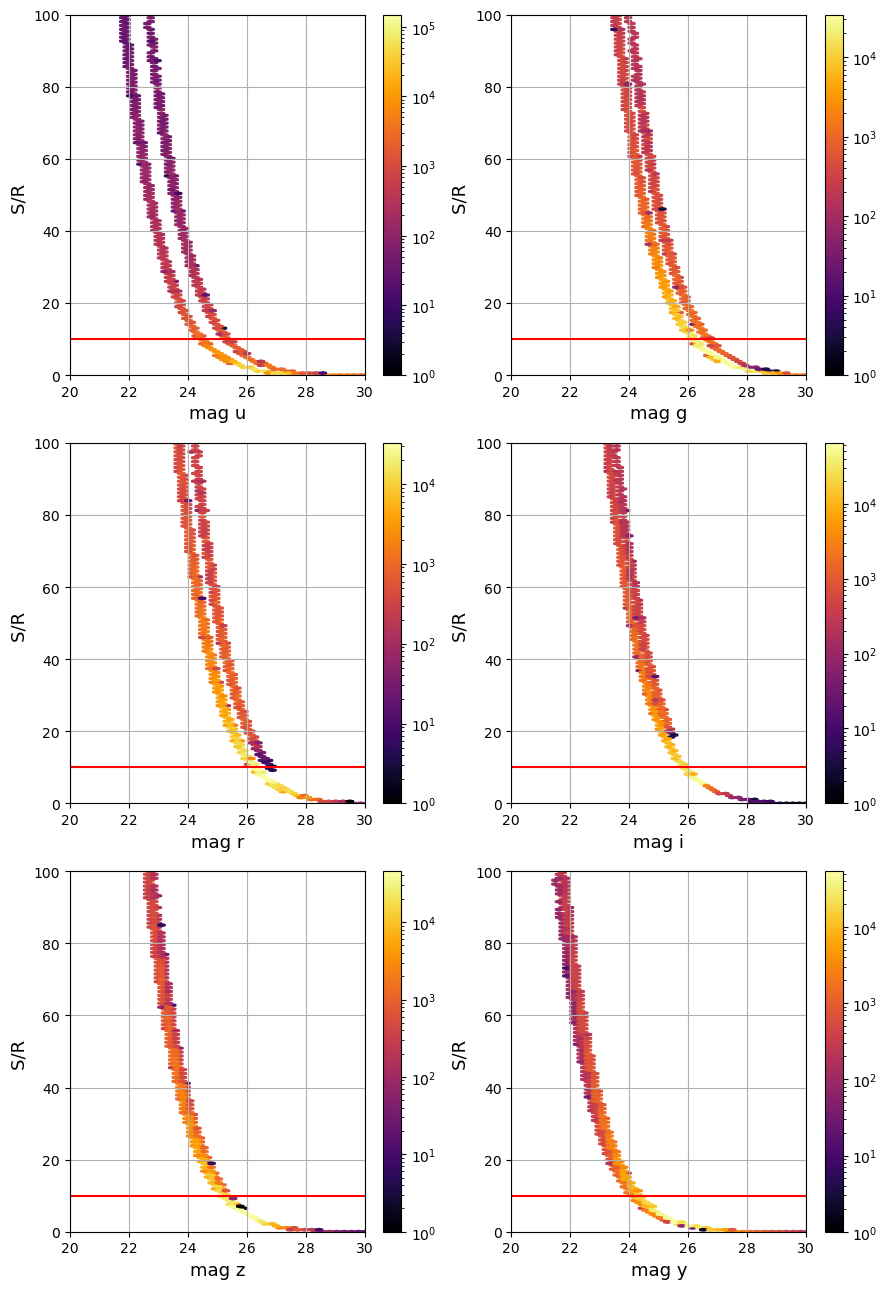

In [19]:
plot_errors(catalog)

### Plot mag hist

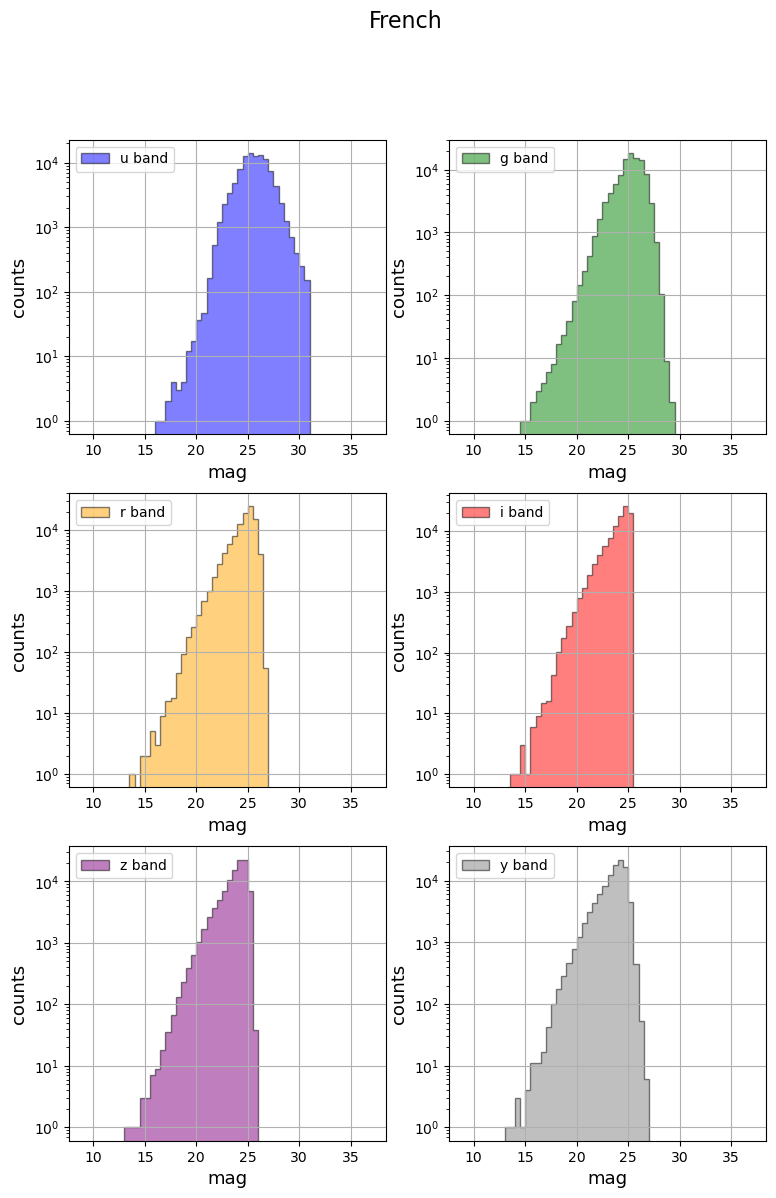

In [20]:
mag_histogram(french,title='French')

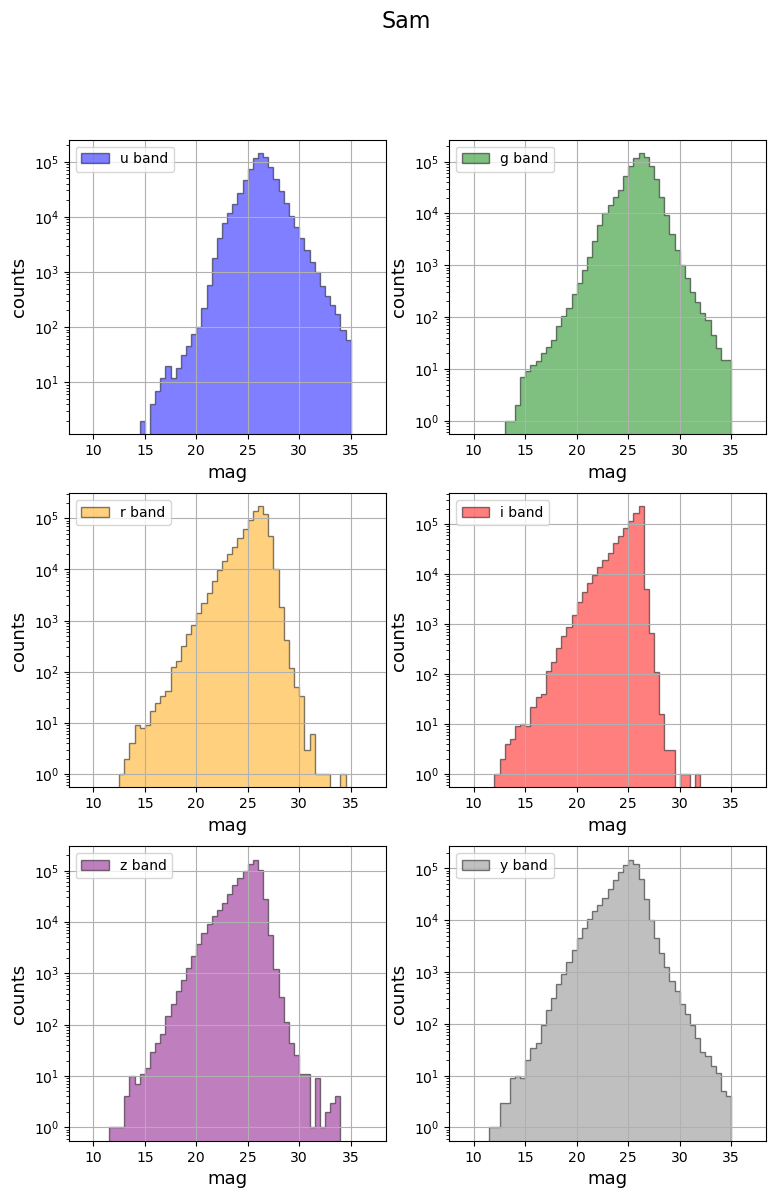

In [21]:
mag_histogram(sam,title='Sam')

### Plot mag x color

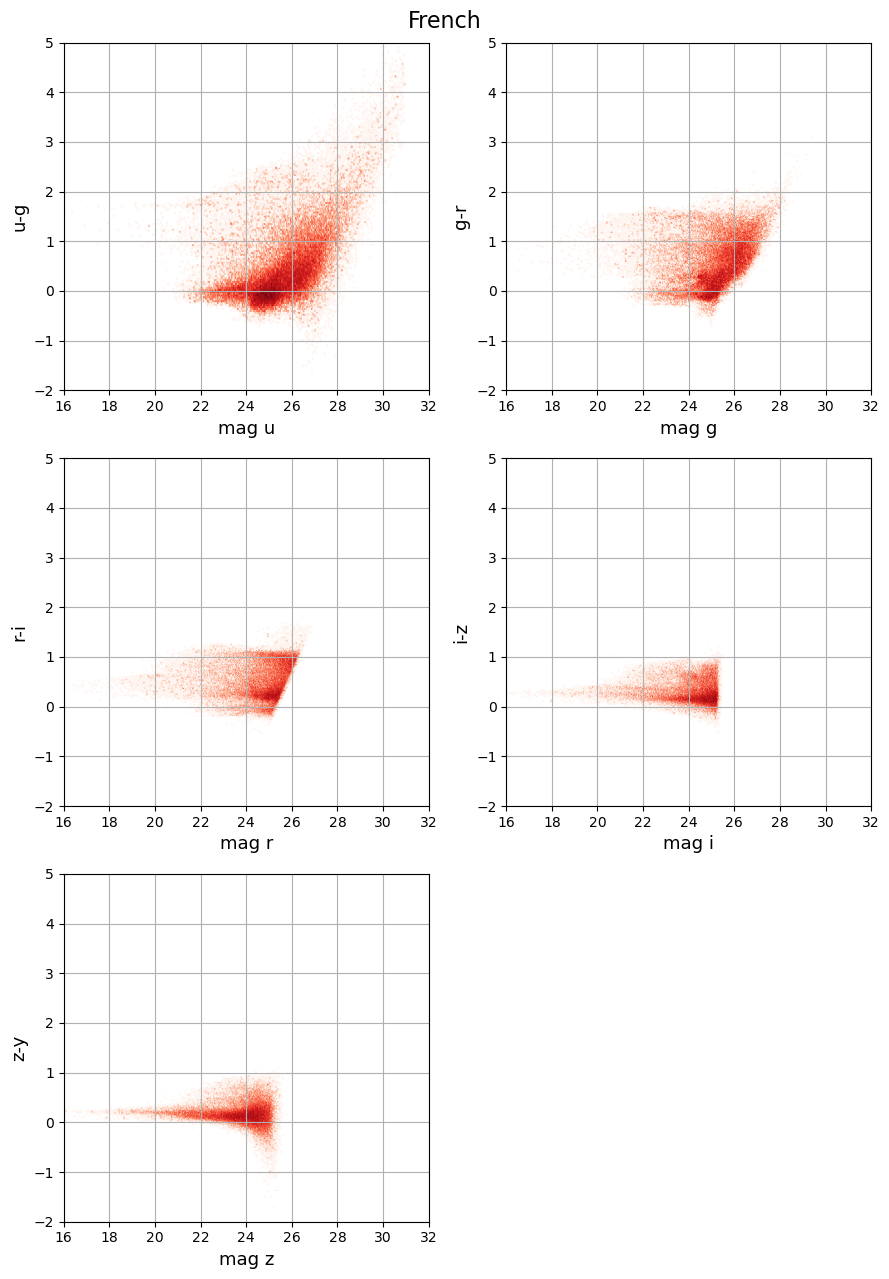

In [22]:
mag_color(french,title='French')

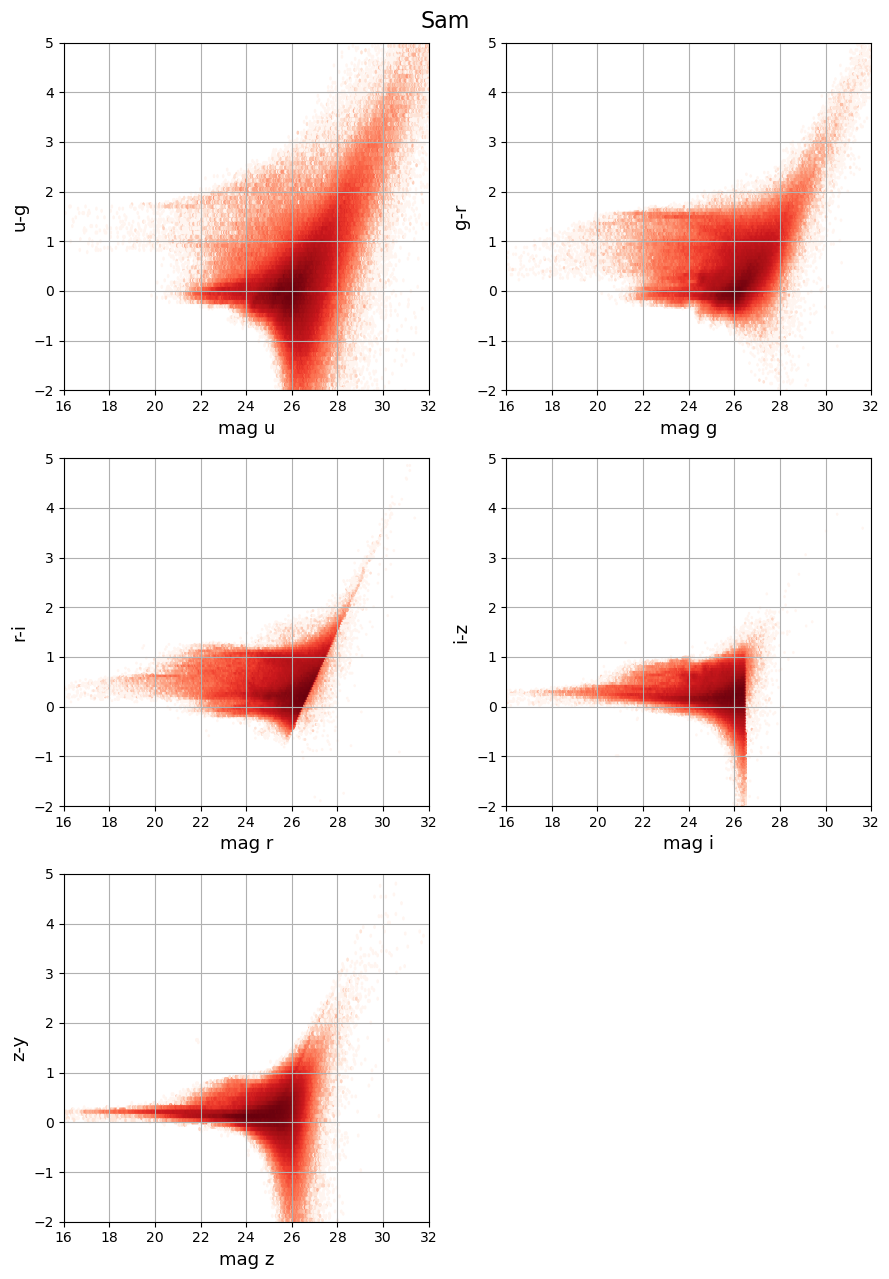

In [23]:
mag_color(sam,title='Sam')

### Plot color x color

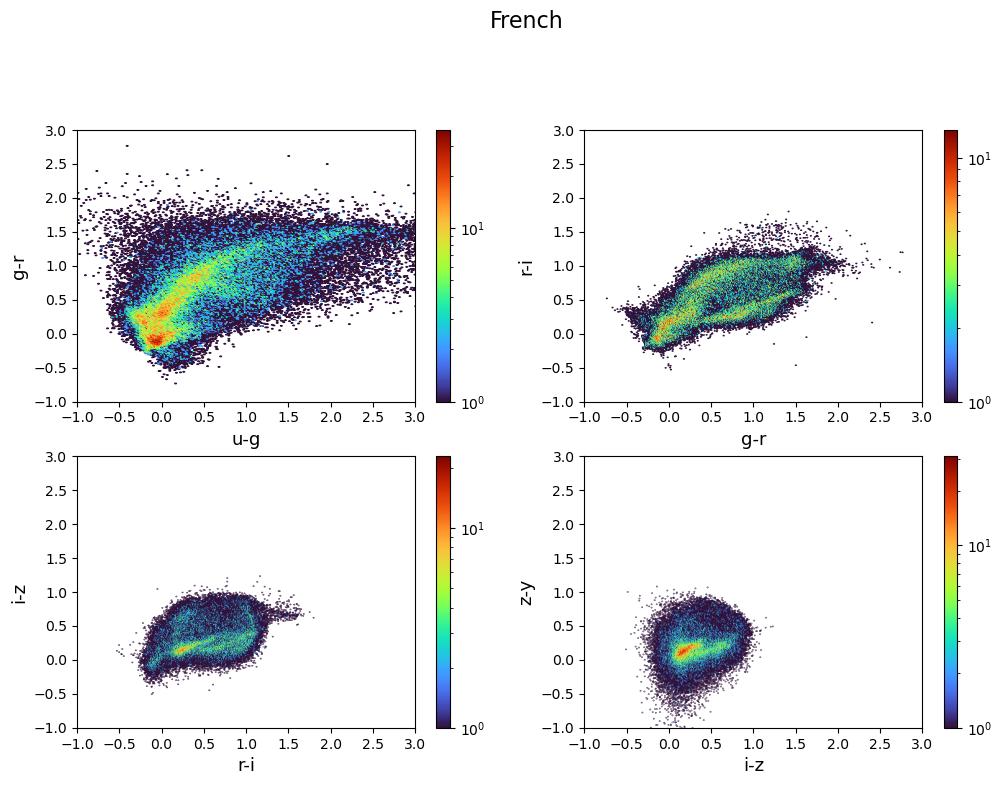

In [24]:
color_color(french,title='French') 

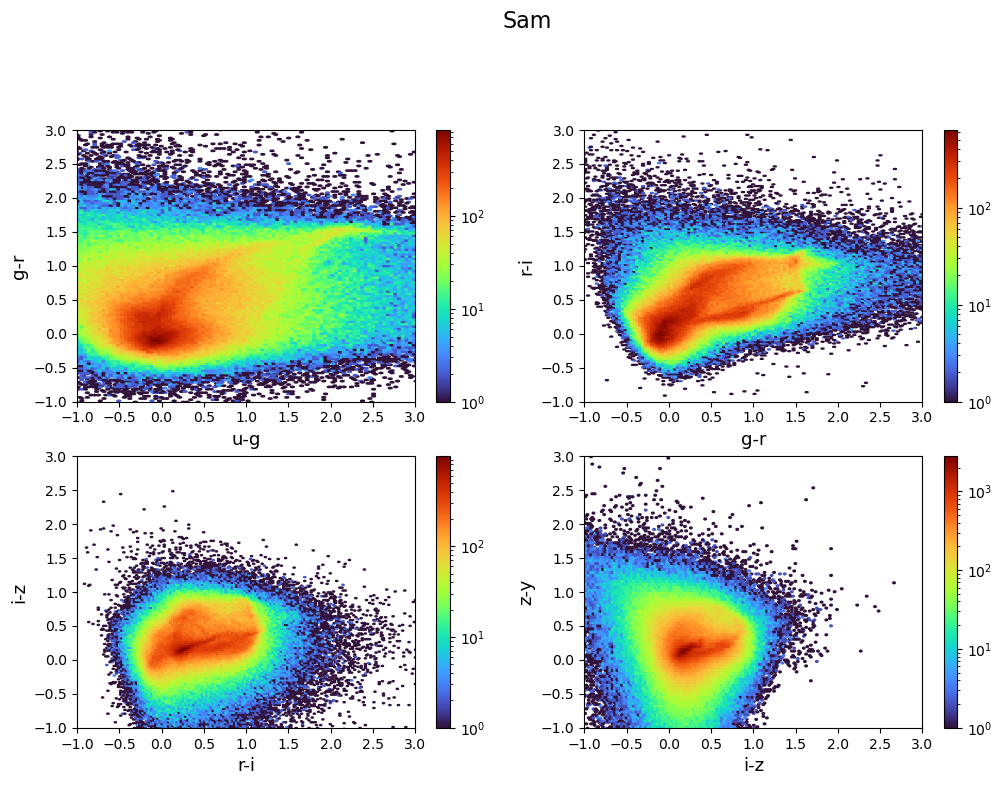

In [25]:
color_color(sam,title='Sam') 

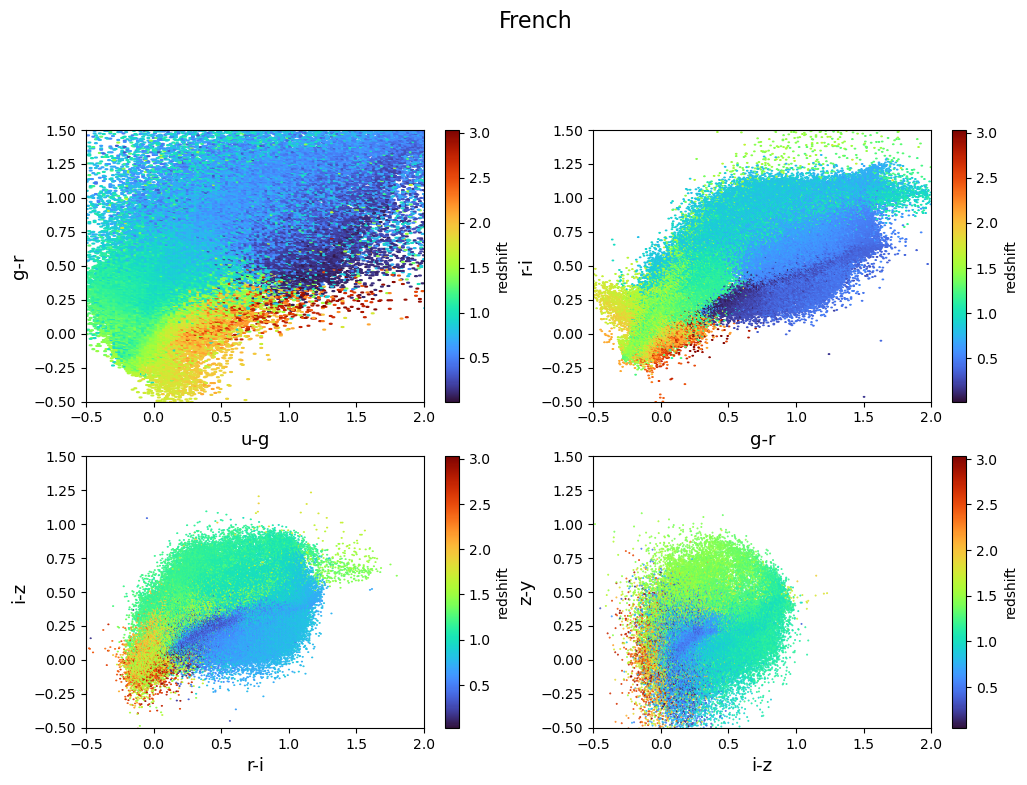

In [26]:
color_color_red(french,[-0.5,2],[-0.5,1.5],title='French')

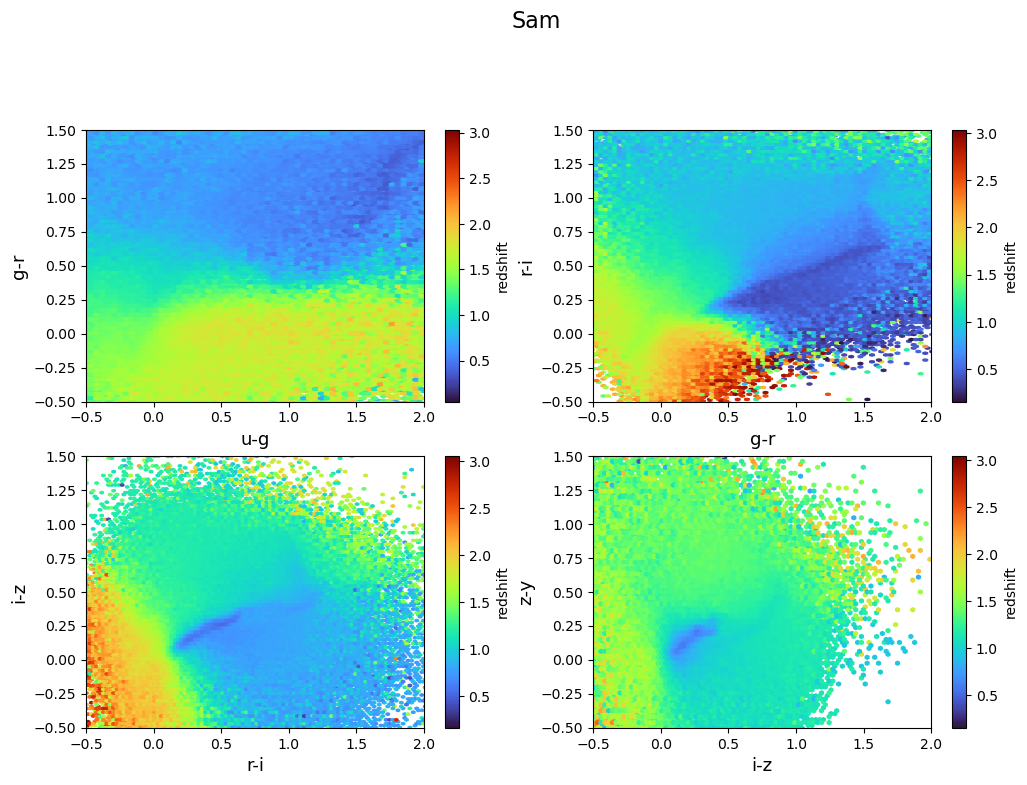

In [27]:
color_color_red(sam,[-0.5,2],[-0.5,1.5],title='Sam')

Text(0, 0.5, 'DEC')

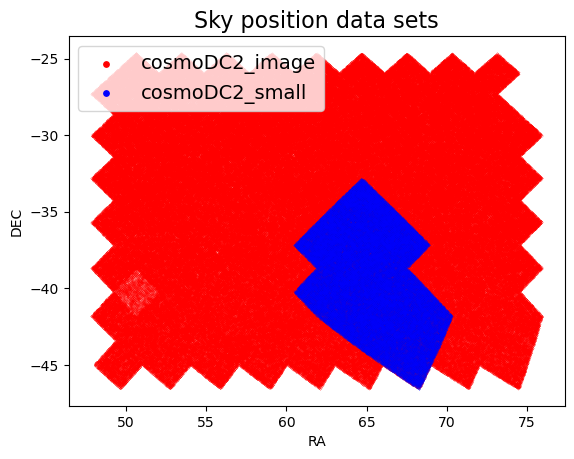

In [28]:
plt.scatter(sam['ra'],sam['dec'], color='red',s=0.01)
plt.scatter(french['ra'],french['dec'], color='blue',s=0.01)
plt.scatter([],[],color='red',s=15,label='cosmoDC2_image')
plt.scatter([],[],color='blue',s=15,label='cosmoDC2_small')
plt.title('Sky position data sets',fontsize='16')
plt.legend(fontsize=14,loc=2)
plt.xlabel('RA')
plt.ylabel('DEC')
#plt.savefig('/home/iago/ic_cosmo/plots/sky_position')

(-35.0, -25.0)

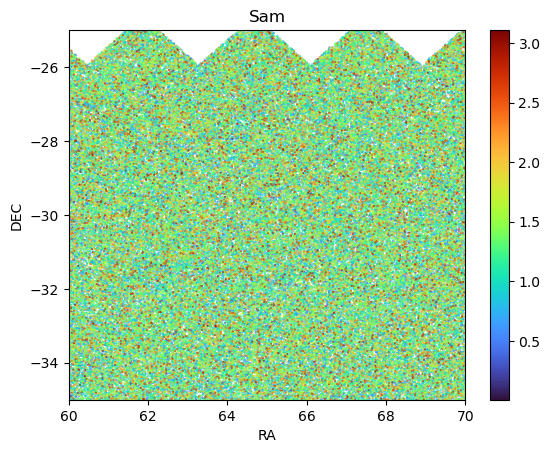

In [34]:
plt.scatter(sam['ra'],sam['dec'], c=sam['redshift'],cmap='turbo',s=0.1)
plt.colorbar()
plt.title('Sam')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(60,70)
plt.ylim(-35,-25)

Text(0, 0.5, 'DEC')

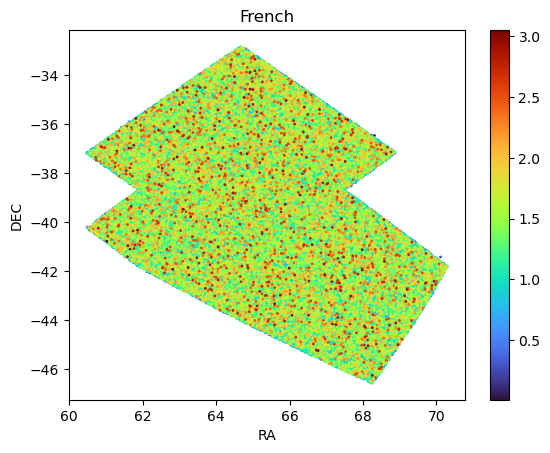

In [30]:
plt.scatter(french['ra'],french['dec'], c=french['redshift'],cmap='turbo',s=1)
plt.colorbar()
plt.title('French')
plt.xlabel('RA')
plt.ylabel('DEC')
#plt.xlim(64,68)
#plt.ylim(-40,-34)

Text(0.5, 0.98, 'Possible LSS in cosmoDC2_small data')

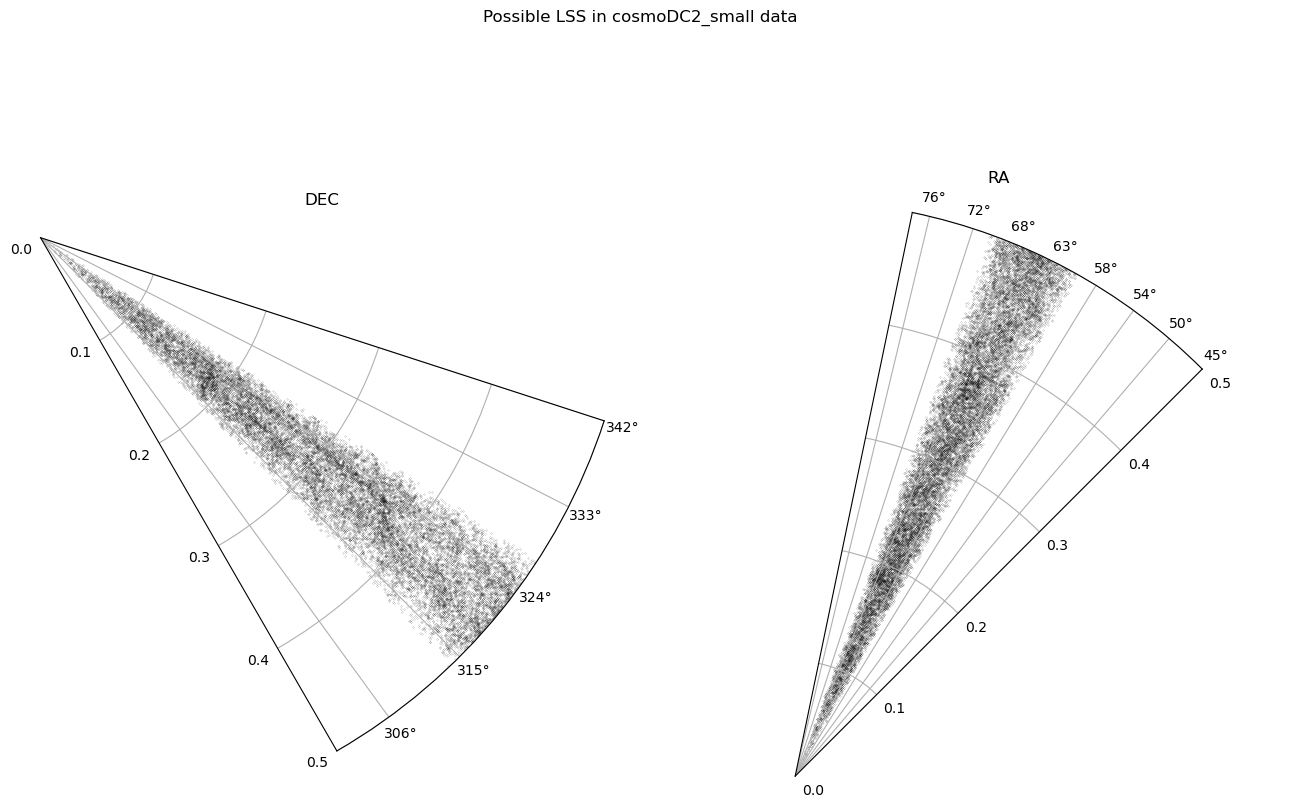

In [31]:
ra = french['ra']*np.pi/180
dec = french['dec']*np.pi/180

ztrue = french['redshift']

x = ztrue*np.cos((ra**2+dec**2)**0.5)
y = ztrue*np.sin((ra**2+dec**2)**0.5)

plt.figure(figsize=(16,10))
plt.subplot(121, polar=True)  # Criando um subplot polar
plt.scatter(dec, ztrue,s=0.009,color='black')
plt.xlim(np.pi*10/6,np.pi*19/10)
plt.ylim(0,0.5)
plt.title('DEC')

plt.subplot(122, polar=True)  # Criando um subplot polar
plt.scatter(ra, ztrue,s=0.009,color='black')
plt.xlim(np.pi/4,np.pi*50/115)
plt.ylim(0,0.5)
plt.title('RA')

plt.suptitle('Possible LSS in cosmoDC2_small data')


Text(0.5, 0.98, 'Possible LSS in cosmoDC2_image data')

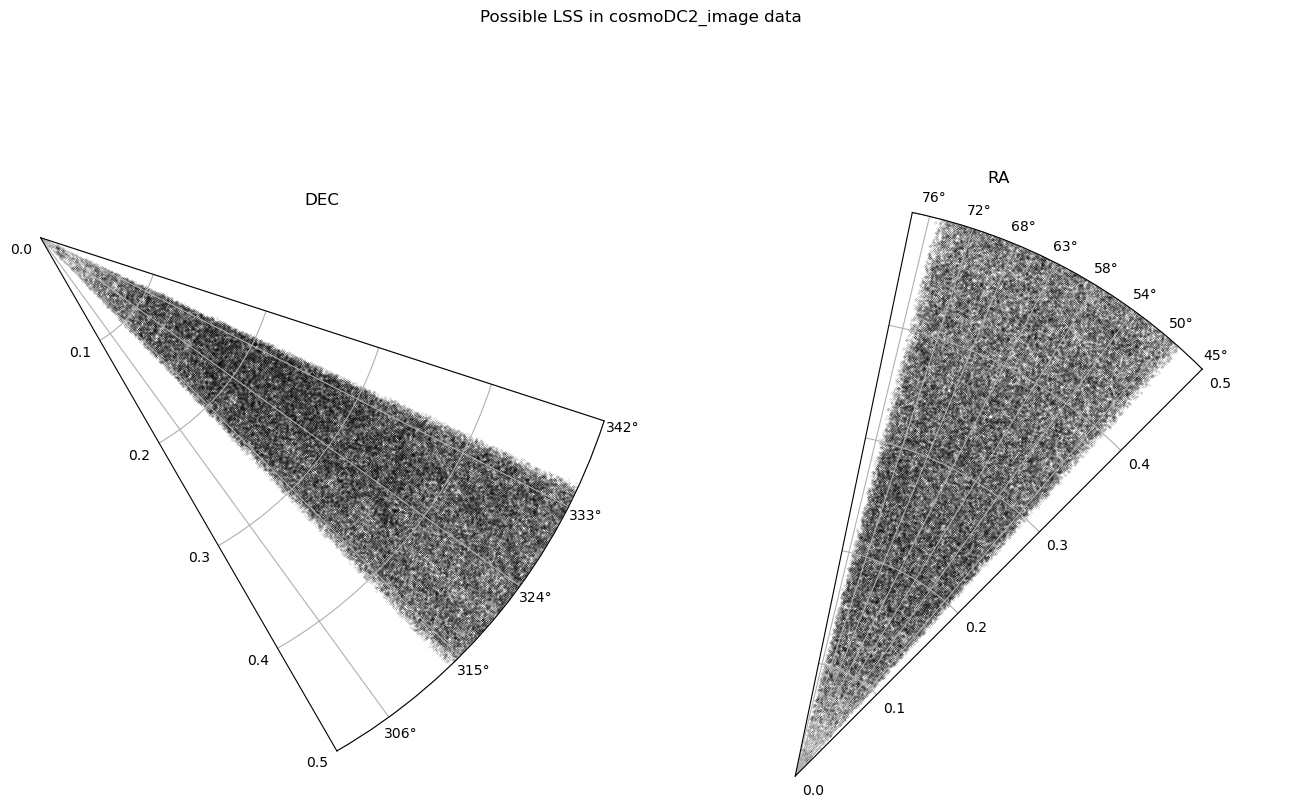

In [32]:
ra = sam['ra']*np.pi/180
dec = sam['dec']*np.pi/180

ztrue = sam['redshift']

x = ztrue*np.cos((ra**2+dec**2)**0.5)
y = ztrue*np.sin((ra**2+dec**2)**0.5)

plt.figure(figsize=(16,10))
plt.subplot(121, polar=True)  # Criando um subplot polar
plt.scatter(dec, ztrue,s=0.009,color='black')
plt.xlim(np.pi*10/6,np.pi*19/10)
plt.ylim(0,0.5)
plt.title('DEC')

plt.subplot(122, polar=True)  # Criando um subplot polar
plt.scatter(ra, ztrue,s=0.009,color='black')
plt.xlim(np.pi/4,np.pi*50/115)
plt.ylim(0,0.5)
plt.title('RA')

plt.suptitle('Possible LSS in cosmoDC2_image data')


## Dividing in training and testing with cuts

In [27]:
sam_train_o=sam_train
sam_test_o=sam_test
french_o=french

In [28]:

# i band
i_band=25
sam_train = sam_train_o[sam_train_o['mag_i_lsst']<i_band]
sam_test = sam_test_o[sam_test_o['mag_i_lsst']<i_band]
french = french_o[french_o['mag_i_lsst']<i_band]
sam = sam[sam['mag_i_lsst']<i_band]

'''
########## cut test
sam = sam[sam['mag_u_lsst']<31]  
sam_train = sam_train[sam_train['mag_u_lsst']<31]
sam_test = sam_test[sam_test['mag_u_lsst']<31]'''

print(f'French: {len(french)}')
print(f'Sam: {len(sam)}')

French: 81080
Sam: 267551


In [29]:
len(sam)==len(sam_train)+len(sam_test)

True

In [30]:
fraction_french = 0.9
fraction_sam = np.round(len(sam_test)/len(sam),2)

french_train = french.sample(round(len(french)*fraction_french),random_state=40)
french_test = french.drop(french_train.index)

## Changing the data to a PqHandle

In [23]:
#french_train_sample = DS.add_data(data=french_train, handle_class=PqHandle, key='redshift_french_train')
sam_train_sample = DS.add_data(data=sam_train, handle_class=PqHandle, key='redshift_sam_train')

In [31]:
#french_test_sample = DS.add_data(data=french_test, handle_class=PqHandle, key='redshift_french_test')
sam_test_sample = DS.add_data(data=sam_test, handle_class=PqHandle, key='redshift_sam_test')

In [25]:
print(f'Train French: {len(french_train_sample.data)}')
print(f'Test French: {len(french_test_sample.data)}')
print(f'Train Sam: {len(sam_train_sample.data)}')
print(f'Test Sam: {len(sam_test_sample.data)}')

NameError: name 'french_train_sample' is not defined

## Getting the maximum and minimum redshift from training sample for FlexzBoost configurations

In [24]:

#z_max_french = max(french_train['redshift'])
#z_min_french = min(french_train['redshift'])
#print(z_max_french)
z_max_sam = max(sam_train['redshift'])
z_min_sam = min(sam_train['redshift'])
print(z_max_sam)

3.0451567840441056


# Configuring algorithm, training and validating

## Setting FlexzBoost

Here we can change the configurations of the algorithm.

List of possible regressions:
reg:squarederror // reg:linear // reg:pseudohubererror // reg:absoluteerror

In [34]:
limits_french = []  # selecting the magnitude limits of each band for FlexzBoost settings
limits_sam = [] 
for band in ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst']:
    #limits_french.append(np.round(max(french_train_sample.data[band]),2))
    limits_sam.append(np.round(max(sam_train_sample.data[band]),2))
#print(f'Limits French: {limits_french}')
print(f'Limits Sam: {limits_sam}')

Limits Sam: [31.0, 29.63, 26.92, 25.0, 25.33, 26.15]


In [25]:
############################ FlexzBoost configurations #########################################

basis_system = 'Fourier'
reg = 'squarederror'
max_basis = 35
depth = 8 
dataset = 'French'

################################################################################################

fz_dict_french = dict(zmin=z_min_french, zmax=z_max_french, nzbins=201,
               trainfrac=fraction_french, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=max_basis, basis_system= basis_system,
               bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_u_lsst':limits_french[0],'mag_g_lsst':limits_french[1],'mag_r_lsst':limits_french[2],'mag_i_lsst':limits_french[3],'mag_z_lsst':limits_french[4],
                           'mag_y_lsst':limits_french[5],},
               hdf5_groupname='',
               regression_params={'max_depth': depth,'objective':f'reg:{reg}'})

fz_modelfile_french = f'FZB_{dataset}_i{int(limits_french[3])}.pkl'

NameError: name 'z_min_french' is not defined

In [28]:
############################ FlexzBoost configurations #########################################

basis_system = 'Fourier'
reg = 'squarederror'
max_basis = 35
depth = 8 
dataset = 'Sam'

################################################################################################

fz_dict_sam = dict(zmin=z_min_sam, zmax=z_max_sam, nzbins=201,
               trainfrac=fraction_sam, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=max_basis, basis_system= basis_system,
               bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_u_lsst':limits_sam[0],'mag_g_lsst':limits_sam[1],'mag_r_lsst':limits_sam[2],'mag_i_lsst':limits_sam[3],'mag_z_lsst':limits_sam[4],
                           'mag_y_lsst':limits_sam[5],},
               hdf5_groupname='',
               regression_params={'max_depth': depth,'objective':f'reg:{reg}'})

fz_modelfile_sam = f'FZB_{dataset}_i{int(limits_sam[3])}.pkl'

## Training (LONG TIME TO RUN!!!)

In [55]:

inform_pzflex = FlexZBoostInformer.make_stage(name=f'inform_fzboost_french', model=fz_modelfile_french, **fz_dict_french)


NameError: name 'fz_modelfile_french' is not defined

In [32]:
print(inform_pzflex.config)
print(max(french_train_sample.data['redshift']))
#print(max(french_test_sample.data['redshift']))

{output_mode:default,zmin:0.0101,zmax:3.0307,nzbins:201,nondetect_val:99.0,mag_limits:{'mag_u_lsst': 30.95, 'mag_g_lsst': 27.1, 'mag_r_lsst': 25.58, 'mag_i_lsst': 24.0, 'mag_z_lsst': 24.13, 'mag_y_lsst': 24.34},bands:['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst'],err_bands:['mag_err_u_lsst', 'mag_err_g_lsst', 'mag_err_z_lsst', 'mag_err_i_lsst', 'mag_err_z_lsst', 'mag_err_y_lsst'],ref_band:mag_i_lsst,redshift_col:redshift,retrain_full:True,trainfrac:0.9,seed:1138,bumpmin:0.02,bumpmax:0.35,nbump:20,sharpmin:0.7,sharpmax:2.1,nsharp:15,max_basis:35,basis_system:Fourier,regression_params:{'max_depth': 8, 'objective': 'reg:squarederror'},name:inform_fzboost_french,model:FZB_French_i24.pkl,hdf5_groupname:,config:None,input:None,aliases:{'model': 'model_inform_fzboost_french'},}
3.0307


In [33]:
%%time
inform_pzflex.inform(french_train_sample) #training algorithm


stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Inserting handle into data store.  model_inform_fzboost_french: inprogress_FZB_French_i24.pkl, inform_fzboost_french
CPU times: user 1min 3s, sys: 23 s, total: 1min 26s
Wall time: 1min 10s


In [29]:

inform_pzflex = FlexZBoostInformer.make_stage(name=f'inform_fzboost_sam', model=fz_modelfile_sam, **fz_dict_sam)


In [30]:
print(inform_pzflex.config)
print(max(sam_train_sample.data['redshift']))
#print(max(sam_test_sample.data['redshift']))

{output_mode:default,zmin:0.007073181137865481,zmax:3.0451567840441056,nzbins:201,nondetect_val:99.0,mag_limits:{'mag_u_lsst': 31.0, 'mag_g_lsst': 29.45, 'mag_r_lsst': 26.86, 'mag_i_lsst': 25.0, 'mag_z_lsst': 25.4, 'mag_y_lsst': 26.01},bands:['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst'],err_bands:['mag_err_u_lsst', 'mag_err_g_lsst', 'mag_err_z_lsst', 'mag_err_i_lsst', 'mag_err_z_lsst', 'mag_err_y_lsst'],ref_band:mag_i_lsst,redshift_col:redshift,retrain_full:True,trainfrac:0.5,seed:1138,bumpmin:0.02,bumpmax:0.35,nbump:20,sharpmin:0.7,sharpmax:2.1,nsharp:15,max_basis:35,basis_system:Fourier,regression_params:{'max_depth': 8, 'objective': 'reg:squarederror'},name:inform_fzboost_sam,model:FZB_Sam_i25_ucut.pkl,hdf5_groupname:,config:None,input:None,aliases:{'model': 'model_inform_fzboost_sam'},}
3.0451567840441056


In [31]:
%%time
inform_pzflex.inform(sam_train_sample) #training algorithm


stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Inserting handle into data store.  model_inform_fzboost_sam: inprogress_FZB_Sam_i25_ucut.pkl, inform_fzboost_sam
CPU times: user 13min 44s, sys: 1min 3s, total: 14min 47s
Wall time: 15min 28s


In [35]:
table_conv_sam = TableConverter.make_stage(name=f'table_Sam_i{int(limits_sam[3])}', output_format='numpyDict');
test_sample_table_sam = table_conv_sam(sam_test_sample) # saving the test file


Inserting handle into data store.  output_table_Sam_i25_ucut: inprogress_output_table_Sam_i25_ucut.hdf5, table_Sam_i25_ucut


In [49]:
test_sample_table_french=french_test_sample
test_sample_table_french.path=f'/home/iago/ic_cosmo/results/output_table_French_i{int(limits_french[3])}.hdf5'
test_sample_table_french.write() # saving the test file

'/home/iago/ic_cosmo/results/output_table_French_i25_testando2.hdf5'

## Testing

In [24]:
import pickle

############################################### config testing here !!! ############################

train_set = 'French' 
mag_train = 25
test_set = 'Sam'
mag_test = 25

#############################################################################################

with open(f'FZB_{train_set}_i{mag_train}.pkl', 'rb') as f: ####### loading the training data
    object = pickle.load(f)


In [25]:
french_test_sample = DS.read_file(f'French_i{mag_test}', Hdf5Handle, 
                          f'/home/iago/ic_cosmo/results/output_table_French_i{mag_test}.hdf5')
sam_test_sample = DS.read_file(f'Sam_i{mag_test}', Hdf5Handle, 
                          f'/home/iago/ic_cosmo/results/output_table_Sam_i{mag_test}.hdf5')

In [26]:
french_test = french_test_sample.data
sam_test = sam_test_sample.data

In [27]:

z_max_french = max(french_test['redshift'])
z_min_french = min(french_test['redshift'])
print(f'z max French: {z_max_french}')
z_max_sam = max(sam_test['redshift'])
z_min_sam = min(sam_test['redshift'])
print(f'z max Sam:{z_max_sam}')

z max French: 3.0182
z max Sam:3.0360601429968392


In [28]:
limits_french = []  # selecting the magnitude limits of each band for FlexzBoost settings
limits_sam = [] 
for band in ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst']:
    limits_french.append(np.round(max(french_test_sample.data[band]),2))
    limits_sam.append(np.round(max(sam_test_sample.data[band]),2))
print(f'Limits French: {limits_french}')
print(f'Limits Sam: {limits_sam}')

Limits French: [30.93, 28.36, 26.51, 25.0, 25.26, 26.21]
Limits Sam: [31.0, 29.63, 26.92, 25.0, 25.33, 26.15]


In [34]:
if test_set == 'French':
    limits = limits_french
    z_max = z_max_french
    testing_sample = french_test_sample
elif test_set == 'Sam':
    limits = limits_sam
    z_max = z_max_sam
    testing_sample = sam_test_sample
else:
    raise ValueError


estimate_fzb = FlexZBoostEstimator.make_stage(
    name=f'estimate_fzb_Train{train_set}_i{mag_train}_Test{test_set}_i{mag_test}', 
    hdf5_groupname='',
    bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
    err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
    mag_limits={'mag_u_lsst':limits[0],'mag_g_lsst':limits[1],'mag_r_lsst':limits[2],'mag_i_lsst':limits[3],'mag_z_lsst':limits[4],'mag_y_lsst':limits[5],},
    model=object,
    filters="path",
    zmax = z_max,
    chunk_size=100000
)

In [35]:
#estimate_fzb.name=f'estimate_fzb_Train{train_set}_i{mag_train}_Test{test_set}_i{mag_test}_agora'
#estimate_fzb.model=object

In [36]:
len(testing_sample.data['redshift'])==len(french_test['redshift'])

False

In [37]:
len(testing_sample.data['redshift'])==len(sam_test['redshift'])

True

In [38]:
len(testing_sample.data['redshift'])

132612

In [39]:
%%time
output_fzb = estimate_fzb.estimate(testing_sample) #testing



Inserting handle into data store.  model: <flexcode.core.FlexCodeModel object at 0x77df3060bef0>, estimate_fzb_TrainSam_i25_TestSam_i25_ucut
Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000
Inserting handle into data store.  output_estimate_fzb_TrainSam_i25_TestSam_i25_ucut: inprogress_output_estimate_fzb_TrainSam_i25_TestSam_i25_ucut.hdf5, estimate_fzb_TrainSam_i25_TestSam_i25_ucut
Process 0 running estimator on chunk 100000 - 132612
Process 0 estimating PZ PDF for rows 100,000 - 132,612
CPU times: user 1min 4s, sys: 8.79 s, total: 1min 13s
Wall time: 1min 12s


# Results

You can analyze the results simply by inserting the directory path !!!

In [3]:
path = '/home/iago/ic_cosmo/results/'#os.getcwd() # you can change this to the path to git file in your local

## Functions

Some of this functions came from LSST github

### old_metrics_table

In [4]:
def old_metrics_table(photoz, ztrue, name="", show_dc1=True):
    rows = ["|Metric |", "|:---|", "|scatter |", "|bias |", "|outlier rate |"]
    sigma_iqr, bias, frac, sigma_mad = old_metrics(photoz, ztrue)
    rows[0] += f"{name} |"
    rows[1] += "---:|"
    rows[2] += f"{sigma_iqr:11.4f} |"
    rows[3] += f"{bias:11.5f} |"
    rows[4] += f"{frac:11.3f} |"
    if show_dc1:
        rows[0] += "DC1 paper"
        rows[1] += "---:"
        rows[2] += f"  0.0154"
        rows[3] += f" -0.00027"
        rows[4] += f"  0.020"
    table = ("\n").join(rows)
    return Markdown(table)


In [5]:
def metrics_table(df):
    rows = ["|Dataset |", "|:---|"]
    metrics = ['cde_loss', 'out_pit']  # Métricas que queremos incluir

    # Adicionando as métricas ao cabeçalho da tabela
    rows[0] += "CDE Loss | Fraction PIT|"
    rows[1] += "---:|---:|"

    # Iterando sobre cada dataset no DataFrame
    for idx, row in df.iterrows():
        dataset = row['dataset']  # Obtendo o nome do dataset
        rows.append(f"|{dataset}{' ' * 10} |")  # Adicionando mais espaços em branco para aumentar o tamanho
        for metric in metrics:
            value = row[metric]  # Obtendo o valor da métrica para o dataset
            rows[-1] += f"{value:10.4f} |"  # Adicionando o valor formatado à linha

    # Juntando todas as linhas em uma tabela Markdown
    table = ("\n").join(rows)
    return Markdown(table)

In [6]:
def old_metrics(photoz, ztrue):
    point = EvaluatePointStats(photoz, ztrue)
    sigma_iqr = point.CalculateSigmaIQR()
    bias = point.CalculateBias()
    frac = point.CalculateOutlierRate()
    sigma_mad = point.CalculateSigmaMAD()
    return sigma_iqr, bias, frac, sigma_mad

In [7]:

class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


### plot_old_valid

In [8]:
def plot_old_valid_comparation(photoz1,photoz, ztrue,title,photoz1name='',photozname='' ,gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot1}$': photoz1,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.scatter(ztrue, photoz1, color='blue', s=0.1,alpha=0.4)
    plt.scatter(ztrue, photoz, color='red',s=0.1 ,alpha=0.4)
    
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'k--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3,color='black')
    sns.kdeplot(photoz, shade=True, label=photozname,bw_adjust=0.3,color='red')
    sns.kdeplot(photoz1, shade=True, label=photoz1name,bw_adjust=0.3,color='blue')
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)

In [9]:
def plot_old_valid(photoz, ztrue,title, gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'r--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, 3)#zmax)
    plt.ylim(0, 3)#zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3)
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$',bw_adjust=0.3)
    plt.xlim(0, 3)#zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)


### plot_metrics

In [10]:
def plot_metrics_comparation(zspec,
                 zphot1,
                 zphot2,
                 maximum,
                 name1='',
                 name2='',
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers1 = []
    sigma68z1 = []
    sigmaz1=[]
    meanz1 = []
    outliers_21 = []
    fraction_outliers1 = []
    sigma68z2 = []
    sigmaz2=[]
    meanz2 = []
    outliers_22 = []
    fraction_outliers2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r1 = zphot1[(zphot1 >= bin_lower) & (zphot1 <= bin_upper)]
        values_s1 = zspec[(zphot1 >= bin_lower) & (zphot1 <= bin_upper)]
        values_r2 = zphot2[(zphot2 >= bin_lower) & (zphot2 <= bin_upper)]
        values_s2 = zspec[(zphot2 >= bin_lower) & (zphot2 <= bin_upper)]
        
        

        deltabias1 = (values_r1 - values_s1)
        deltabias2 = (values_r2 - values_s2)
        
        mean_bias1 = np.mean(deltabias1)  # Mean bias for each bin
        meanz1.append(mean_bias1)
        mean_bias2 = np.mean(deltabias2)  # Mean bias for each bin
        meanz2.append(mean_bias2)
        
    
        s1 = np.sort(np.abs(deltabias1/(1+values_s1)))
        s2 = np.sort(np.abs(deltabias2/(1+values_s2)))# Standard deviation (sigma) for each bin
        sigma681 = s1[int(len(s1)*0.68)]
        sigma68z1.append(sigma681)
        sigma682 = s2[int(len(s2)*0.68)]
        sigma68z2.append(sigma682)
        
        
        
        sigma1 = (np.sum((values_r1-values_s1-mean_bias1)**2)/len(values_r1))**0.5
        sigmaz1.append(sigma1)
        sigma2 = (np.sum((values_r2-values_s2-mean_bias2)**2)/len(values_r2))**0.5
        sigmaz2.append(sigma2)
    
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers1 = deltabias1[np.abs(deltabias1-mean_bias1) > 3 * sigma1]
        fraction_outlier1 = len(outliers1) / len(deltabias1)
        fraction_outliers1.append(fraction_outlier1)
        outliers2 = deltabias2[np.abs(deltabias2 - mean_bias2) > 3 * sigma2]
        fraction_outlier2 = len(outliers2) / len(deltabias2)
        fraction_outliers2.append(fraction_outlier2)

        
    
        #2 sigma
        outliers21 = deltabias1[np.abs(deltabias1-mean_bias1) > 2 * sigma1]
        fraction_outlier21 = len(outliers21) / len(deltabias1)
        outliers_21.append(fraction_outlier21)
        outliers22 = deltabias2[np.abs(deltabias2 - mean_bias2) > 2 * sigma2]
        fraction_outlier22 = len(outliers22) / len(deltabias2)
        outliers_22.append(fraction_outlier22)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz1, 'bo-',label=name1)
    axes[0].plot(points[:-1], meanz2, 'ro-',label=name2)
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.05,0.05)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)
    axes[0].legend(loc=1)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z1, 'bo-',label=name1)
    axes[1].plot(points[:-1], sigma68z2, 'ro-',label=name2)
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.1)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)
    axes[1].legend(loc=1)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_21,'o-',color='blue',label=name1)
    axes[2].plot(points[:-1],outliers_22,'o-',color='red',label=name2)
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[2].legend(loc=1)

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers1, 'bo-',label=name1)
    axes[3].plot(points[:-1], fraction_outliers2, 'ro-',label=name2)
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.04)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
    axes[3].legend(loc=1)
   
    
    plt.suptitle(title)
    plt.xlim(0,3.1)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


In [11]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.02,0.02)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.05)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.02)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,3)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


### plot_scatter

In [12]:
def plot_scatter(zspec,zphot,catalog):
    kde = gaussian_kde([zspec, zphot])

    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(min(zphot), max(zphot))
    plt.ylim(min(zphot), max(zphot))
    plt.title(f'FzBoost_{catalog}')

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

### plot_pit_qq

In [13]:
def ks_plot(pitobj, n_quant=100):
    """ KS test illustration.
    Ancillary function to be used by class KS."""
    pits = np.array(pitobj.pit_samps)
    stat_and_pval = pitobj.evaluate_PIT_KS()
    xvals = np.linspace(0., 1., n_quant)
    yvals = np.array([np.histogram(pits, bins=len(xvals))[0]])
    pit_cdf = Ensemble(interp, data=dict(xvals=xvals, yvals=yvals)).cdf(xvals)[0]
    uniform_yvals = np.array([np.full(n_quant, 1.0 / float(n_quant))])
    uniform_cdf = Ensemble(interp, data=dict(xvals=xvals, yvals=uniform_yvals)).cdf(xvals)[0]

    plt.figure(figsize=[4, 4])
    plt.plot(xvals, uniform_cdf, 'r-', label="uniform")
    plt.plot(xvals, pit_cdf, 'b-', label="sample PIT")
    bin_stat = np.argmax(np.abs(pit_cdf - uniform_cdf))

    plt.vlines(x=xvals[bin_stat],
               ymin=np.min([pit_cdf[bin_stat], uniform_cdf[bin_stat]]),
               ymax=np.max([pit_cdf[bin_stat], uniform_cdf[bin_stat]]),
               colors='k')
    plt.plot(xvals[bin_stat], pit_cdf[bin_stat], "k.")
    plt.plot(xvals[bin_stat], uniform_cdf[bin_stat], "k.")
    ymean = (pit_cdf[bin_stat] + uniform_cdf[bin_stat]) / 2.
    plt.text(xvals[bin_stat] + 0.05, ymean, "max", fontsize=16)
    plt.xlabel("PIT value")
    plt.ylabel("CDF(PIT)")
    xtext = 0.63
    ytext = 0.03
    plt.text(xtext, ytext, f"KS={stat_and_pval.statistic:.4f}", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()


In [14]:
def plot_pit_qq(pdfs, zgrid, ztrue, bins=None, title=None, code=None,
                show_pit=True, show_qq=True,
                pit_out_rate=None, savefig=False) -> str:
    """Quantile-quantile plot
    Ancillary function to be used by class Metrics.

    Parameters
    ----------
    pit: `PIT` object
        class from metrics.py
    bins: `int`, optional
        number of PIT bins
        if None, use the same number of quantiles (sample.n_quant)
    title: `str`, optional
        if None, use formatted sample's name (sample.name)
    label: `str`, optional
        if None, use formatted code's name (sample.code)
    show_pit: `bool`, optional
        include PIT histogram (default=True)
    show_qq: `bool`, optional
        include QQ plot (default=True)
    pit_out_rate: `ndarray`, optional
        print metric value on the plot panel (default=None)
    savefig: `bool`, optional
        save plot in .png file (default=False)
    """

    if bins is None:
        bins = 100
    if title is None:
        title = ""

    if code is None:
        code = ""
        label = ""
    else:
        label = code + "\n"


    if pit_out_rate is not None:
        try:
            label += "PIT$_{out}$: "
            label += f"{float(pit_out_rate):.4f}"
        except:
            print("Unsupported format for pit_out_rate.")

    plt.figure(figsize=[4, 5])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    sample = Sample(pdfs, zgrid, ztrue)

    if show_qq:
        ax0.plot(sample.qq[0], sample.qq[1], c='r',
                 linestyle='-', linewidth=3, label=label)
        ax0.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=2)
        ax0.set_ylabel("Q$_{data}$", fontsize=18)
        plt.ylim(-0.001, 1.001)
    plt.xlim(-0.001, 1.001)
    plt.title(title)
    if show_pit:
        fzdata = Ensemble(interp, data=dict(xvals=zgrid, yvals=pdfs))
        pitobj = PIT(fzdata, ztrue)
        pit_vals = np.array(pitobj.pit_samps)
        pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

        try:
            y_uni = float(len(pit_vals)) / float(bins)
        except:
            y_uni = float(len(pit_vals)) / float(len(bins))
        if not show_qq:
            ax0.hist(pit_vals, bins=bins, alpha=0.7, label=label)
            ax0.set_ylabel('Number')
            ax0.hlines(y_uni, xmin=0, xmax=1, color='k')
            plt.ylim(0, )  # -0.001, 1.001)
        else:
            ax1 = ax0.twinx()
            ax1.hist(pit_vals, bins=bins, alpha=0.7)
            ax1.set_ylabel('Number')
            ax1.hlines(y_uni, xmin=0, xmax=1, color='k')
    leg = ax0.legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)
    if show_qq:
        ax2 = plt.subplot(gs[1])
        ax2.plot(sample.qq[0], (sample.qq[1] - sample.qq[0]), c='r', linestyle='-', linewidth=3)
        plt.ylabel("$\Delta$Q", fontsize=18)
        ax2.plot([0, 1], [0, 0], color='k', linestyle='--', linewidth=2)
        plt.xlim(-0.001, 1.001)
        plt.ylim(np.min([-0.12, np.min(sample.qq[1] - sample.qq[0]) * 1.05]),
                 np.max([0.12, np.max(sample.qq[1] - sample.qq[0]) * 1.05]))
    if show_pit:
        if show_qq:
            plt.xlabel("Q$_{theory}$ / PIT Value", fontsize=18)
        else:
            plt.xlabel("PIT Value", fontsize=18)
    else:
        if show_qq:
            plt.xlabel("Q$_{theory}$", fontsize=18)
    if savefig:
        fig_filename = str("plot_pit_qq_" +
                           f"{(code).replace(' ', '_')}.png")
        plt.savefig(fig_filename)
    else:
        fig_filename = None

    return fig_filename


class Sample(Ensemble):
    """ Expand qp.Ensemble to append true redshifts
    array, metadata, and specific plots. """

    def __init__(self, pdfs, zgrid, ztrue, photoz_mode=None, code="", name="", n_quant=100):
        """Class constructor

        Parameters
        ----------
        pdfs: `ndarray`
            photo-z PDFs array, shape=(Ngals, Nbins)
        zgrid: `ndarray`
            PDF bins centers, shape=(Nbins,)
        ztrue: `ndarray`
            true redshifts, shape=(Ngals,)
        photoz_mode: `ndarray`
            photo-z (PDF mode), shape=(Ngals,)
        code: `str`, (optional)
            algorithm name (for plot legends)
        name: `str`, (optional)
            sample name (for plot legends)
        """

        super().__init__(interp, data=dict(xvals=zgrid, yvals=pdfs))
        self._pdfs = pdfs
        self._zgrid = zgrid
        self._ztrue = ztrue
        self._photoz_mode = photoz_mode
        self._code = code
        self._name = name
        self._n_quant = n_quant
        self._pit = None
        self._qq = None


    @property
    def code(self):
        """Photo-z code/algorithm name"""
        return self._code

    @property
    def name(self):
        """Sample name"""
        return self._name

    @property
    def ztrue(self):
        """True redshifts array"""
        return self._ztrue

    @property
    def zgrid(self):
        """Redshift grid (binning)"""
        return self._zgrid

    @property
    def photoz_mode(self):
        """Photo-z (mode) array"""
        return self._photoz_mode

    @property
    def n_quant(self):
        return self._n_quant

    @property
    def pit(self):
        if self._pit is None:
            pit_array = np.array([self[i].cdf(self.ztrue[i])[0][0] for i in range(len(self))]) 
            self._pit = pit_array
        return self._pit

    @property
    def qq(self, n_quant=100):
        q_theory = np.linspace(0., 1., n_quant)
        q_data = np.quantile(self.pit, q_theory)
        self._qq = (q_theory, q_data)
        return self._qq

    def __len__(self):
        if len(self._ztrue) != len(self._pdfs):
            raise ValueError("Number of pdfs and true redshifts do not match!!!")
        return len(self._ztrue)

    def __str__(self):
        code_str = f'Algorithm: {self._code}'
        name_str = f'Sample: {self._name}'
        line_str = '-' * (max(len(code_str), len(name_str)))
        text = str(line_str + '\n' +
                   name_str + '\n' +
                   code_str + '\n' +
                   line_str + '\n' +
                   f'{len(self)} PDFs with {len(self.zgrid)} probabilities each \n' +
                   f'qp representation: {self.gen_class.name} \n' +
                   f'z grid: {len(self.zgrid)} z values from {np.min(self.zgrid)} to {np.max(self.zgrid)} inclusive')
        return text

### plot metrics distribution

In [15]:
def plot_metrics_distribution(metamets,title,path_to_save=''):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.set_ylabel('KS', fontsize=16)
    ax1.scatter(1-0.05, metamets['ks'][0], color='blue', marker='D', s=70)
    ax1.axhline(10**-2, ls='--', xmin=0.1, xmax=0.9, color='blue')
    ax1.scatter(2-0.05, 0.0240, color='blue', marker='D', s=70, label='KS')
    ax1.set_yscale('log')
    ax1.set_ylim(3.5*10**-3, 0.16)
    ax1.set_xticks((1, 2))
    ax1.set_xticklabels([f'{name_test}', 'DC1'], fontsize=15)
    ax1.set_xlim(0, 3)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('CvM', fontsize=16)
    ax2.scatter(1, metamets['cvm'].statistic, color='black', marker='*', s=100)
    ax2.axhline(5, ls='--', xmin=0.1, xmax=0.9, color='black')
    ax2.scatter(2, 68.3, color='black', marker='*', s=100)
    ax2.set_yscale('log')
    ax2.set_yticks([1, 10, 100, 1000])
    ax2.set_ylim(0.5, 5*10**3)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('AD', fontsize=16)
    ax3.scatter(1+0.05, metamets['ad'].statistic, color='red', marker='x', s=100)
    ax3.axhline(35, ls='--', xmin=0.1, xmax=0.9, color='red')
    ax3.scatter(2+0.05, 478.8, color='red', marker='x', s=100)
    ax3.tick_params(axis='y')
    ax3.set_yscale('log')
    ax3.set_ylim(4, 2.4*10**4)


    legend_ks = ax1.legend(['KS','KS Bootstrap error'], loc='upper center', bbox_to_anchor=(0.15, 1.1), fontsize=12)
    legend_cvm = ax2.legend(['CvM','CvM Bootstrap error'], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12)
    legend_ad = ax3.legend(['AD','AD Bootstrap error'], loc='upper center', bbox_to_anchor=(0.85, 1.1), fontsize=12)

    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()



###### the difference is the limits of the plot and the Sam values

def plot_metrics_distribution_n(metamets, title, path_to_save=''):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.set_ylabel('KS', fontsize=16)
    ax1.scatter(1-0.05, metamets['ks'][0], color='blue', marker='D', s=70)
    ax1.axhline(10**-2, ls='--', xmin=0.1, xmax=0.9, color='blue')
    ax1.scatter(2-0.05, 1.1*10**-2, color='blue', marker='D', s=70, label='KS')
    ax1.set_yscale('log')
    ax1.set_ylim(6*10**-3,3*10**-2)
    ax1.set_xticks((1, 2))
    ax1.set_xticklabels([f'{name_test}', 'DC1'], fontsize=15)
    ax1.set_xlim(0, 3)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('CvM', fontsize=16)
    ax2.scatter(1, metamets['cvm'].statistic, color='black', marker='*', s=100)
    ax2.axhline(4, ls='--', xmin=0.1, xmax=0.9, color='black')
    ax2.scatter(2, 0.7*10**1, color='black', marker='*', s=100)
    ax2.set_yscale('log')
    ax2.set_yticks([0.1,1, 10,100])
    ax2.set_ylim(0.005, 1.7*10**2)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('AD', fontsize=16)
    ax3.scatter(1+0.05, metamets['ad'].statistic, color='red', marker='x', s=100)
    ax3.axhline(26, ls='--', xmin=0.1, xmax=0.9, color='red')
    ax3.scatter(2+0.05, 1.2*10**2, color='red', marker='x', s=100)
    ax3.tick_params(axis='y')
    ax3.set_yscale('log')
    ax3.set_yticks([10**-1,1,10**1,10**2,10**3])
    ax3.set_ylim(4, 2*10**3)


    legend_ks = ax1.legend(['KS','KS Bootstrap error'], loc='upper center', bbox_to_anchor=(0.15, 1.1), fontsize=12)
    legend_cvm = ax2.legend(['CvM','CvM Bootstrap error'], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12)
    legend_ad = ax3.legend(['AD','AD Bootstrap error'], loc='upper center', bbox_to_anchor=(0.85, 1.1), fontsize=12)

    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()





def plot_moments_n(hist_true, hist_n, title, path_to_save=''):


    nz = hist_n[0]
    zgrid_n = hist_n[1]
    
    z = hist_true[0]
    zgrid_z = hist_true[1]
    

    # moments for the expected N(z)
    mean_n = np.average(zgrid_n, weights=nz)
    variance_n = np.average((zgrid_n - mean_n) ** 2, weights=nz)
    skew_n = np.average(((zgrid_n - mean_n) / np.sqrt(variance_n))**3, weights=nz)

    # moments for the true N(z)
    mean_z = np.average(zgrid_z, weights=z)
    variance_z = np.average((zgrid_z - mean_z) ** 2, weights=z)
    skew_z = np.average(((zgrid_z - mean_z) / np.sqrt(variance_z))**3, weights=z)
    


    
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.set_ylabel('Δz^m', fontsize=16)
    ax1.scatter(1,mean_n-mean_z, color='red', marker='D', s=70,label='Mean(m=1)')
    ax1.scatter(1,variance_n-variance_z, color='blue', marker='*', s=70,label='Variance(m=2)')
    ax1.scatter(1,skew_n-skew_z, color='black', marker='X', s=70, label='Skewness(m=3)')
    
    ax1.scatter(2,-0.01, color='red', marker='D', s=70)
    ax1.scatter(2,-0.02, color='blue', marker='*', s=70)
    ax1.scatter(2,-0.04, color='black', marker='X', s=70)

    
    ax1.axhline(0,ls='--',color='black')
    ax1.axhline(-0.005,ls='--',color='blue')
    ax1.axhline(0.005,ls='--',color='blue')
    ax1.axhline(-0.003,ls='--',color='red')
    ax1.axhline(0.003,ls='--',color='red')
    
    
    ax1.set_ylim(-0.05,0.05)
    ax1.set_xticks((1, 2))
    ax1.set_xticklabels([f'{name_test}', 'DC1'], fontsize=15)
    ax1.set_xlim(0.5, 2.5)
    ax1.legend()

    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()
    return [mean_z-mean_n,variance_z-variance_n,skew_z-skew_n]


### Points Stats

In [16]:
class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all
        

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


### Plots for all data sets

In [17]:
def plot_all_moments(df, title, path_to_save=''):
    ''' 
    Function to plot all moments given a dataframe which the columns are the moments 
    and one column should contain all the names for each dataset.

    '''

    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.set_ylabel('Δz^m', fontsize=16)
    
    for i in range(len(df['mean'])):
        ax1.scatter(i,df['mean'][i], color='red', marker='D', s=70)
        ax1.scatter(i,df['variance'][i], color='blue', marker='*', s=70)
        ax1.scatter(i,df['skew'][i], color='black', marker='X', s=70)
        #ax1.scatter(x_axis[i],df['rms'], color='green', marker='1', s=70, label='RMS scatter')
    
    ax1.scatter(i+1,-0.01, color='red', marker='D', s=70,label='mean')
    ax1.scatter(i+1,-0.02, color='blue', marker='*', s=70,label='variance')
    ax1.scatter(i+1,-0.04, color='black', marker='X', s=70,label='skewness')

    
    ax1.axhline(0,ls='--',color='black')
    ax1.axhline(-0.005,ls='--',color='blue',label='Y10 SRD Req variance')
    ax1.axhline(0.005,ls='--',color='blue')
    ax1.axhline(-0.003,ls='--',color='red',label='Y10 SRD Red mean')
    ax1.axhline(0.003,ls='--',color='red')
    
    names = df['dataset'] 
    
    #ax1.set_ylim(-0.05,0.05)
    ax1.set_xticks(range(len(df['mean'])+1))
    ax1.set_xticklabels(np.append(names,'DC1'), fontsize=5)
    ax1.set_xlim(-1, len(df['mean'])+1)
    ax1.legend()

    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()
    

In [18]:
def plot_all_metrics_n(df, title, path_to_save=''):
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()  
    ax3 = ax1.twinx()  
    
    for i in range(len(df['ks_n'])):
        ax1.scatter(i-0.05, df['ks_n'][i], color='blue', marker='D', s=70)
        ax2.scatter(i, df['cvm_n'][i], color='black', marker='*', s=100)
        ax3.scatter(i+0.05, df['ad_n'][i], color='red', marker='x', s=100)

        
    ax1.set_ylabel('KS', fontsize=16)
    ax1.axhline(10**-2, ls='--', xmin=0.1, xmax=0.9, color='blue')
    ax1.set_yscale('log')
    ax1.set_ylim(1.5*10**-3,3*10**-1)
    ax1.set_xticks(range(len(df['ks_n'])+1))
    ax1.set_xticklabels(np.append(df['dataset'],'DC1'), fontsize=5)
    ax1.set_xlim(-1, len(df['ks_n'])+1)


    ax2.set_ylabel('CvM', fontsize=16)
    ax2.axhline(4, ls='--', xmin=0.1, xmax=0.9, color='black')
    ax2.set_yscale('log')
    #ax2.set_yticks([0.1,1, 10,100])
    #ax2.set_ylim(0.005, 1.7*10**2)


    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('AD', fontsize=16)
    ax3.axhline(26, ls='--', xmin=0.1, xmax=0.9, color='red')
    ax3.tick_params(axis='y')
    ax3.set_yscale('log')
    #ax3.set_yticks([10**-1,1,10**1,10**2,10**3])
    #ax3.set_ylim(4, 2*10**3)
    ax1.scatter(i+1-0.05, 1.1*10**-2, color='blue', marker='D', s=70, label='KS')
    ax2.scatter(i+1, 0.7*10**1, color='black', marker='*', s=100)
    ax3.scatter(i+1+0.05, 1.2*10**2, color='red', marker='x', s=100)

    legend_ks = ax1.legend(['KS','KS Bootstrap error'], loc='upper center', bbox_to_anchor=(0.15, 1.1), fontsize=12)
    legend_cvm = ax2.legend(['CvM','CvM Bootstrap error'], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12)
    legend_ad = ax3.legend(['AD','AD Bootstrap error'], loc='upper center', bbox_to_anchor=(0.85, 1.1), fontsize=12)

    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()


In [19]:
def plot_all_metrics(df, title, path_to_save=''):
    ''' 
    Function to plot all moments given a dataframe which the columns are the moments 
    and one column should contain all the names for each dataset.

    '''

    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    for i in range(len(df['bias'])):
        ax1.scatter(i,np.abs(df['bias'][i]), color='red', marker='D', s=70)
        ax1.scatter(i,df['rms'][i], color='blue', marker='*', s=70)
        ax1.scatter(i,df['f_out'][i], color='black', marker='X', s=70)
        #ax1.scatter(x_axis[i],df['rms'], color='green', marker='1', s=70, label='RMS scatter')
    
    ax1.scatter(i+1,-0.00027, color='red', marker='D', s=70,label='bias')
    ax1.scatter(i+1,0.0154, color='blue', marker='*', s=70,label='rms')
    ax1.scatter(i+1,0.02, color='black', marker='X', s=70,label='f_out')
    
    
    ax1.axhline(0.1,ls='--',color='black',label='Y10 req f_out')
    ax1.axhline(-0.02,ls='--',color='blue',label='Y10 Req rms')
    ax1.axhline(0.02,ls='--',color='blue')
    ax1.axhline(-0.003,ls='--',color='red',label='Y10 Red bias')
    ax1.axhline(0.003,ls='--',color='red')
    
    names = df['dataset'] 
    
    #ax1.set_ylim(-0.05,0.05)
    ax1.set_xticks(range(len(df['mean'])+1))
    ax1.set_xticklabels(np.append(names,'DC1'), fontsize=5)
    ax1.set_xlim(-1, len(df['mean'])+1)
    ax1.legend()
    ax1.set_ylim(-0.001,0.09)
    
    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()

In [20]:
def plot_all_metrics_pit(df,title,path_to_save=''):
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()  
    ax3 = ax1.twinx()  
    
    for i in range(len(df['ks_pit'])):
        ax1.scatter(i-0.05, df['ks_pit'][i], color='blue', marker='D', s=70)
        ax2.scatter(i, df['cvm_pit'][i], color='black', marker='*', s=100)
        ax3.scatter(i+0.05, df['ad_pit'][i], color='red', marker='x', s=100)

        
    ax1.set_ylabel('KS', fontsize=16)
    ax1.axhline(10**-2, ls='--', xmin=0.1, xmax=0.9, color='blue')
    ax1.set_yscale('log')
    ax1.set_ylim(1.5*10**-3,3*10**-1)
    ax1.set_xticks(range(len(df['ks_pit'])+1))
    ax1.set_xticklabels(np.append(df['dataset'],'DC1'), fontsize=5)
    ax1.set_xlim(-1, len(df['ks_pit'])+1)


    ax2.set_ylabel('CvM', fontsize=16)
    ax2.axhline(4, ls='--', xmin=0.1, xmax=0.9, color='black')
    ax2.set_yscale('log')
    #ax2.set_yticks([0.1,1, 10,100])
    #ax2.set_ylim(0.005, 1.7*10**2)


    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('AD', fontsize=16)
    ax3.axhline(26, ls='--', xmin=0.1, xmax=0.9, color='red')
    ax3.tick_params(axis='y')
    ax3.set_yscale('log')
    #ax3.set_yticks([10**-1,1,10**1,10**2,10**3])
    #ax3.set_ylim(4, 2*10**3)

    
    ax1.scatter(i+1-0.05, 2.1*10**-2, color='blue', marker='D', s=70, label='KS')
    ax2.scatter(i+1, 0.8*10**2, color='black', marker='*', s=100)
    ax3.scatter(i+1+0.05, 7*10**2, color='red', marker='x', s=100)

    legend_ks = ax1.legend(['KS','KS Bootstrap error'], loc='upper center', bbox_to_anchor=(0.15, 1.1), fontsize=12)
    legend_cvm = ax2.legend(['CvM','CvM Bootstrap error'], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12)
    legend_ad = ax3.legend(['AD','AD Bootstrap error'], loc='upper center', bbox_to_anchor=(0.85, 1.1), fontsize=12)

    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    
    if path_to_save=='':
        None
    else:
        plt.savefig(path_to_save)
        
    plt.show()



## Loading data and preparing for plots

### For one result

In [21]:
train= 'Sam'
mag_train = 25
test = 'Sam'
mag_test = 25

In [22]:
name_test=''
name_train=''
if train=='Sam':
    name_train='image'
elif train=='French':
    name_train='small'
if test=='Sam':
    name_test='image'
elif test=='French':
    name_test='small'


In [23]:
result = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/output_estimate_fzb_Train{train}_i{mag_train}_Test{test}_i{mag_test}.hdf5')

In [24]:
############### True redshift #############
catalog = DS.read_file(f'test{test}_{mag_test}',Hdf5Handle,f'{path}/output_table_{test}_i{mag_test}.hdf5')
ztrue =  catalog.data['redshift']

############### Max redshift ##############
z_max = result().build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid = np.linspace(0, z_max, 301)

################## PDFS ##################
pdfs = result().build_tables()['data']['yvals']


In [25]:
mean = result().mean()
#mode = result().mode(zgrid)

########## Median or mode of PDF ##########

zphot  = np.array([valor for sublista in mean for valor in sublista])

### For two results

In [30]:
train1 = 'Sam' #### train1 must be different than test1 if you want to compare different train and tests
mag_train1=25
test1 = 'French'
mag_test1 = 25
train2 = 'French'
mag_train2=25
test2 = 'French'
mag_test2=25

In [31]:
name_test1=''
name_train1=''
if train1=='Sam':
    name_train1='image'
elif train1=='French':
    name_train1='small'
if test1=='Sam':
    name_test1='image'
elif test1=='French':
    name_test1='small'
name_test2 = ''
name_train2 = ''
if train2 == 'Sam':
    name_train2 = 'image'
elif train2 == 'French':
    name_train2 = 'small'
if test2 == 'Sam':
    name_test2 = 'image'
elif test2 == 'French':
    name_test2 = 'small'



In [32]:
result1 = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/output_estimate_fzb_Train{train1}_i{mag_train1}_Test{test1}_i{mag_test1}.hdf5')

result2 = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/output_estimate_fzb_Train{train2}_i{mag_train2}_Test{test2}_i{mag_test2}.hdf5')

In [33]:
############### True redshift #############
catalog = DS.read_file('',Hdf5Handle,f'{path}/output_table_{test2}_i{mag_test2}.hdf5')
ztrue =  catalog.data['redshift']

############### Max redshift ##############
z_max1 = result1().build_tables()['meta']['xvals'][0][-1]
z_max2 = result2().build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid1 = np.linspace(0, z_max1, 301)
zgrid2 = np.linspace(0, z_max2, 301)
################## PDFS ##################
pdfs1 = result1().build_tables()['data']['yvals']
pdfs2 = result2().build_tables()['data']['yvals']

In [34]:
mean1 = result1().mean()
mean2 = result2().mean()

########## Median or mode of PDF ##########

zphot1  = np.array([valor for sublista in mean1 for valor in sublista]) # Choose mode or mean
zphot2  = np.array([valor for sublista in mean2 for valor in sublista])

## N(z)

### Naive Stack

In [26]:
all_metrics = {}

In [27]:

stacker = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=3.0, nzbins=300, nsamples=20, output=f"Naive_samples_Test{test}_i{mag_test}.hdf5", single_NZ=f"NaiveStack_NZ_Test{test}_i{mag_test}.hdf5")


In [28]:
naive_results = stacker.summarize(result)

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 50000
Process 0 running estimator on chunk 50000 - 60000
Process 0 running estimator on chunk 60000 - 70000
Process 0 running estimator on chunk 70000 - 80000
Process 0 running estimator on chunk 80000 - 90000
Process 0 running estimator on chunk 90000 - 100000
Process 0 running estimator on chunk 100000 - 110000
Process 0 running estimator on chunk 110000 - 120000
Process 0 running estimator on chunk 120000 - 130000
Process 0 running estimator on chunk 130000 - 132612
Inserting handle into data store.  output: inprogress_Naive_samples_TestSam_i25.hdf5, NaiveStackSummarizer
Inserting handle into data store.  single_NZ: inprogress_NaiveStack_NZ_TestSam_i25.hdf5, NaiveStackSummarizer


In [29]:
newens = naive_results.data

In [30]:
nz = np.mean(newens.objdata()['yvals'],axis=0)

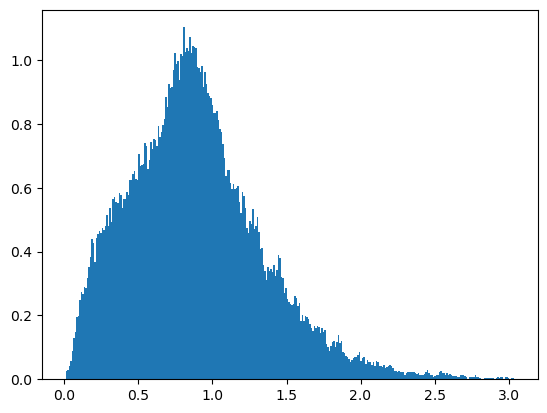

In [31]:
z = plt.hist(ztrue,bins=zgrid,density=True)

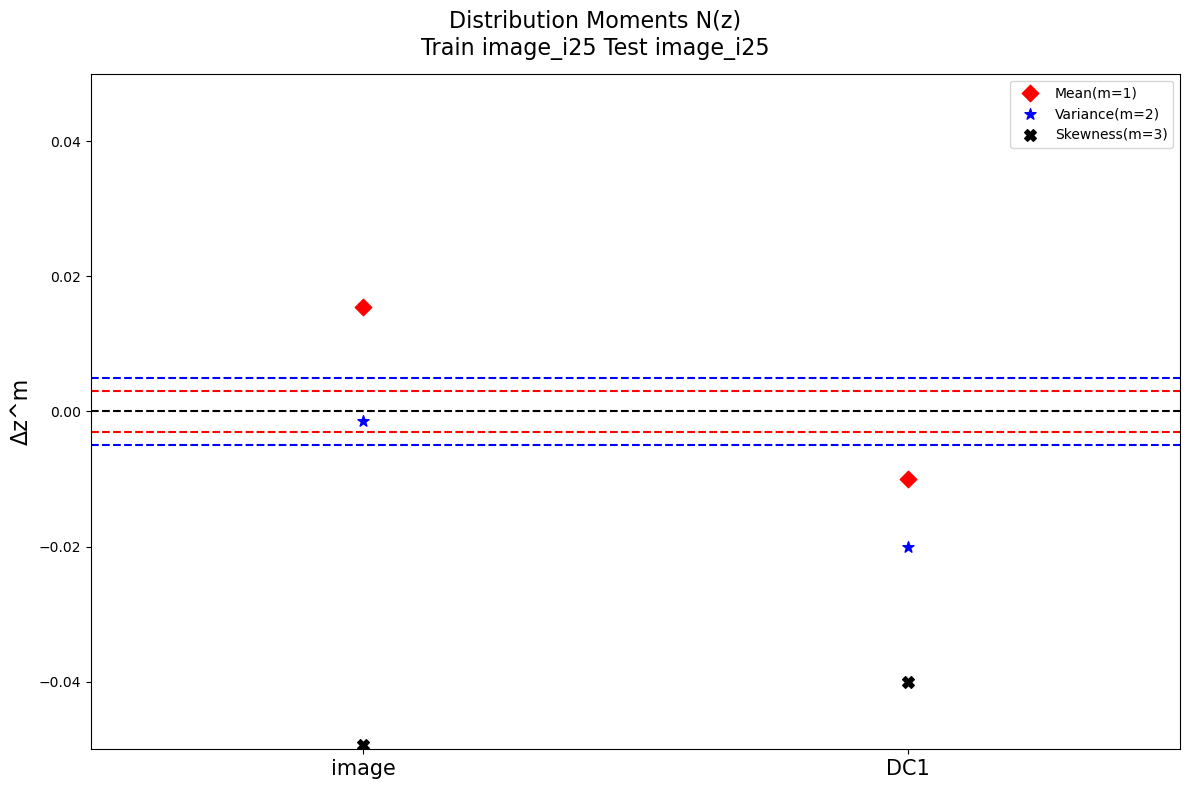

In [32]:
values = plot_moments_n([z[0],z[1][:-1]],[nz,zgrid],title=f'Distribution Moments N(z)\nTrain {name_train}_i{mag_train} Test {name_test}_i{mag_train}'
                       )#,path_to_save=f'/home/iago/ic_cosmo/plots/distribution_moments_nz Train{train}_i{mag_train} Test{test}_i{mag_test}')

In [33]:
all_metrics['mean']=[values[0]]
all_metrics['variance']=[values[1]]
all_metrics['skew']=[values[2]]


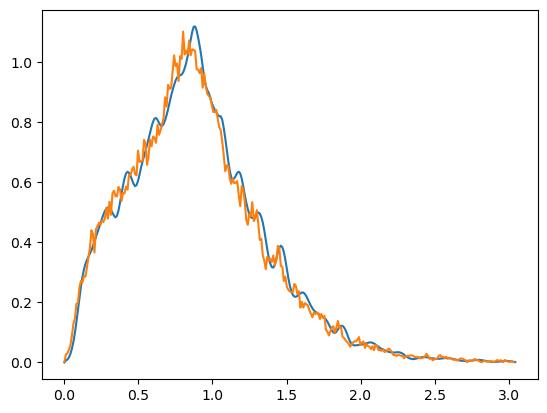

In [34]:
plt.plot(zgrid,nz)
plt.plot(zgrid[:-1],z[0])

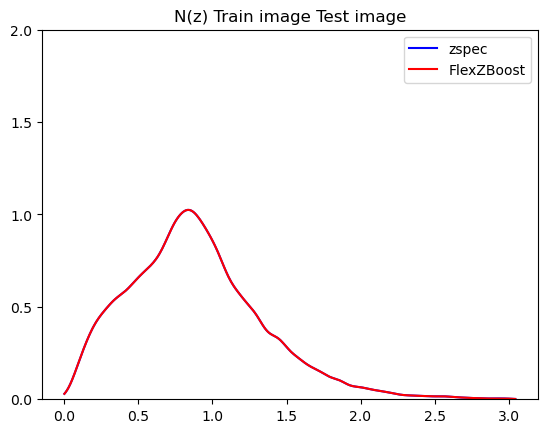

In [35]:
kde = gaussian_kde(ztrue)
kde.set_bandwidth(bw_method='silverman')
x_vals = np.linspace(min(zgrid), max(zgrid), 301)
smoothed = kde.evaluate(x_vals)
plt.plot(x_vals, smoothed, color='blue', label='zspec')


kden = gaussian_kde(nz)
x = np.linspace(min(zgrid), max(zgrid), 1000)
y = kde(x)
plt.plot(x, y, color='red', label='FlexZBoost')

plt.yticks([0,0.5,1,1.5,2])
plt.ylim(0,2)
plt.title(f'N(z) Train {name_train} Test {name_test}')
plt.legend()

In [36]:
from scipy import stats
from qp.metrics.array_metrics import quick_anderson_ksamp

In [37]:
def pdf_to_cdf(pdf):
    cdf = np.cumsum(pdf)
    # Normaliza para garantir que a CDF atinja 1
    cdf = cdf / cdf[-1]
    return cdf
    
cdf_n = pdf_to_cdf(nz)
cdf_z = pdf_to_cdf(z[0])

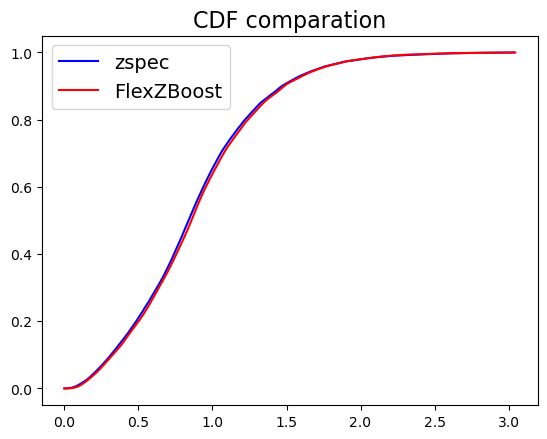

In [38]:
plt.plot(zgrid[:-1],cdf_z,label='zspec',color='blue')
plt.plot(zgrid,cdf_n,label='FlexZBoost',color='red')
plt.title('CDF comparation',fontsize=16)
plt.legend(fontsize=14)

In [39]:
cvm = stats.cramervonmises_2samp(cdf_n,cdf_z)
ks = stats.ks_2samp(cdf_n,cdf_z)
ad = quick_anderson_ksamp(cdf_n,cdf_z)

metamets_n={'ad':ad,'ks':ks,'cvm':cvm}

In [40]:
metamets_n

{'ad': Anderson_ksampResult(statistic=-1.2295289669033689, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.25),
 'ks': KstestResult(statistic=0.022535991140642305, pvalue=0.9999940311176402, statistic_location=0.9936431092208852, statistic_sign=-1),
 'cvm': CramerVonMisesResult(statistic=0.007600202136345047, pvalue=0.9999999555466309)}

In [41]:
all_metrics['ad_n']=[metamets_n['ad'].statistic]
all_metrics['ks_n']=[metamets_n['ks'].statistic]
all_metrics['cvm_n']=[metamets_n['cvm'].statistic]

Text(0.5, 0.98, 'N(z) Naive Stack')

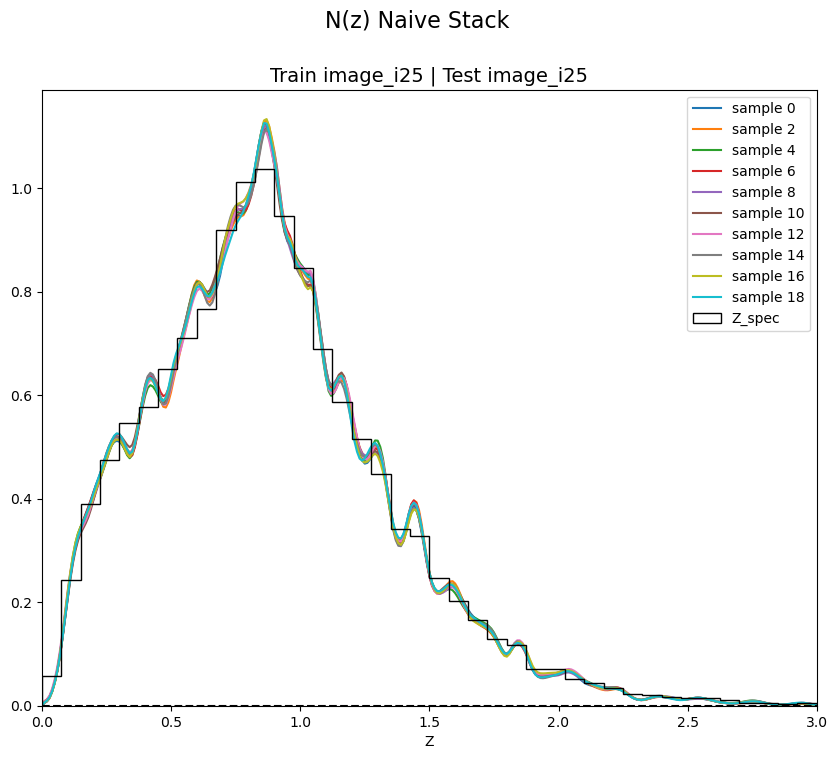

In [43]:
fig, axs = plt.subplots(figsize=(10,8))
for i in range(0, 20, 2):
    newens[i].plot_native(axes=axs, label=f"sample {i}")
axs.plot([0,3],[0,0],'k--')
axs.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,3,41),color='black',label='Z_spec')
axs.set_xlim(0,3)
axs.set_xlabel('Z')
axs.legend(loc='upper right')
axs.set_title(f'Train {name_train}_i{mag_train} | Test {name_test}_i{mag_test}',fontsize=14)
plt.suptitle('N(z) Naive Stack',fontsize=16)
#plt.savefig(f'/home/iago/ic_cosmo/plots/Nz_Train{train}_i{mag_train} Test{test}_i{mag_test}')

Text(0.5, 0.98, 'N(z) Naive Stack')

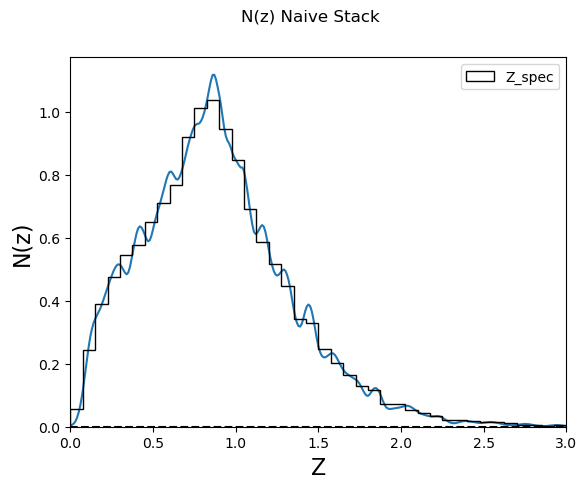

In [44]:
naive_nz = qp.read(f"NaiveStack_NZ_Test{test}_i{mag_test}.hdf5")
naive_nz.plot_native(xlim=(0,3))
plt.plot([0,3],[0,0],'k--')
plt.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,3,41),color='black',label='Z_spec')
plt.xlabel('Z')
plt.legend(loc='upper right')
plt.suptitle('N(z) Naive Stack')

### VarInfStackSummarizer

In [168]:
runner=VarInfStackSummarizer.make_stage(name=f'test_varinf_{test}_i{mag_test}', zmin=0.0,zmax=3.0,nzbins=25, niter=10, nsamples=20,
                                    output="sampletest.hdf5", single_NZ=f"varinf_NZ_Test{test}_i{mag_test}.hdf5")

In [47]:
%%time
varinf_results = runner.summarize(result)

Process 0 running estimator on chunk 0 - 40540
Inserting handle into data store.  output_test_varinf_French_i25: inprogress_sampletest.hdf5, test_varinf_French_i25
Inserting handle into data store.  single_NZ_test_varinf_French_i25: inprogress_varinf_NZ_TestFrench_i25.hdf5, test_varinf_French_i25
CPU times: user 1.93 s, sys: 208 ms, total: 2.14 s
Wall time: 2.15 s


In [48]:
vens = varinf_results.data
vens

<Axes: xlabel='redshift', ylabel='p(z)'>

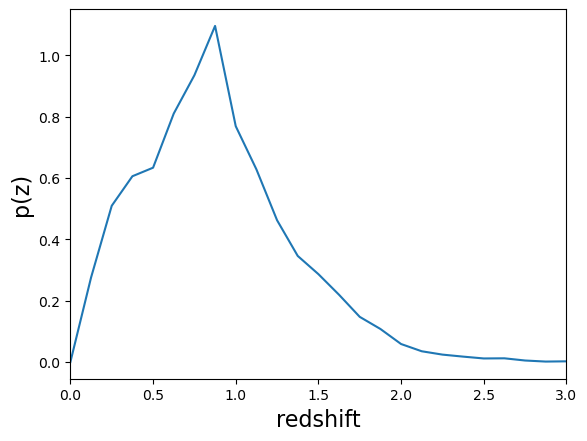

In [50]:
varinf_nz = qp.read(f"varinf_NZ_Test{test}.hdf5")
varinf_nz.plot_native(xlim=(0,3))

## Plots 

### For one result

In [26]:
ez = (zphot-ztrue)/(1+ztrue)

In [27]:
metrics = EvaluatePointStats(zphot,ztrue)
delta_z = zphot-ztrue
rms = np.sqrt(np.mean((ez-np.mean(ez))**2))

print(f'RMS LSST requirement: 0.02')
print(f'RMS: {np.round(rms,4)} ')
print(f'Bias LSST requirement: 0.003')
print(f'Bias: {np.round(np.abs(metrics.CalculateBias()),5)}')
print(f'Fraction Outliers LSST requirement: 0.1')
print(f'Fraction Outliters: {np.round(metrics.CalculateOutlierRate(),4)}')

RMS LSST requirement: 0.02
RMS: 0.0464 
Bias LSST requirement: 0.003
Bias: 0.0001
Fraction Outliers LSST requirement: 0.1
Fraction Outliters: 0.0295


In [28]:
all_metrics['rms']=[rms]
all_metrics['bias']=[metrics.CalculateBias()]
all_metrics['f_out']=[metrics.CalculateOutlierRate()]

NameError: name 'all_metrics' is not defined

Text(0.5, 0, 'zphot')

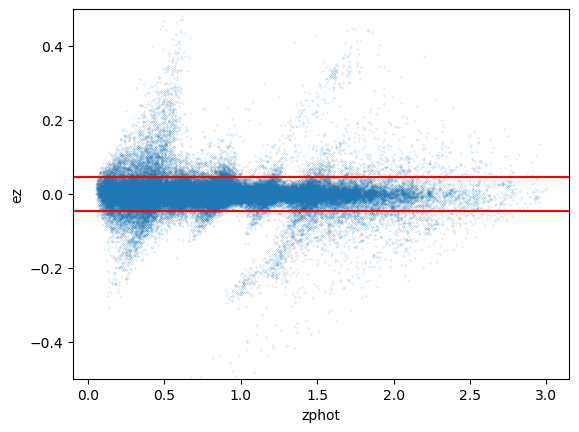

In [29]:
plt.scatter(zphot,ez,s=0.01)
plt.axhline(rms,color='red')
plt.axhline(-rms,color='red')
plt.ylim(-0.5,0.5)
plt.ylabel('ez')
plt.xlabel('zphot')

Text(0.5, 0, 'zphot')

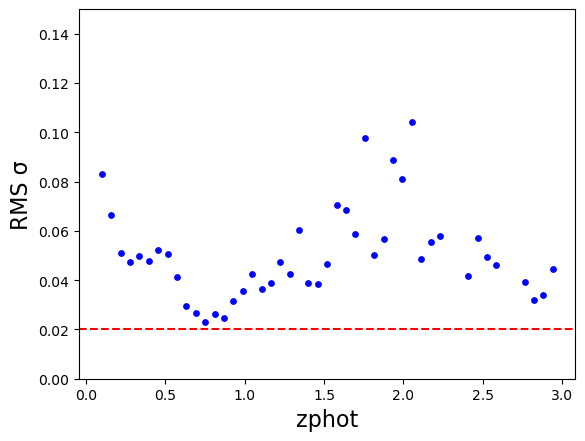

In [30]:
z_bins = np.linspace(0.1,3,50)
rms_all=[]

for i in range(len(z_bins[:-1])):
    mask = (zphot>z_bins[i])&(zphot<z_bins[i+1])
    
    delta = zphot[mask] - ztrue[mask]
    ez_i = (delta)/(1+ztrue[mask])
    
    rms_i = np.sqrt(np.mean((ez_i-np.mean(ez_i))**2))
    rms_all.append(rms_i)

plt.scatter(z_bins[:-1],rms_all,s=15,color='blue')
plt.ylim(0,0.15)
plt.axhline(0.02,color='red',ls='--')
plt.ylabel('RMS σ',fontsize=16)
plt.xlabel('zphot',fontsize=16)

(-0.02, 0.02)

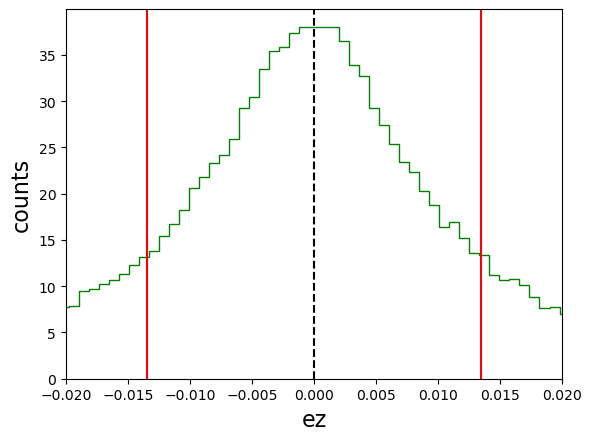

In [31]:
c = plt.hist(ez,bins=np.linspace(-0.04,0.04,100),density=True,histtype='step',color='green')

plt.axvline(-metrics.CalculateSigmaIQR(),color='red')
plt.axvline(metrics.CalculateSigmaIQR(),color='red')
plt.axvline(0,ls='--',color='black')
plt.ylabel('counts',fontsize=16)
plt.xlabel('ez',fontsize=16)
plt.xlim(-0.02,0.02)

Text(0.5, 1.0, 'Train image_i25 | Test image_i25')

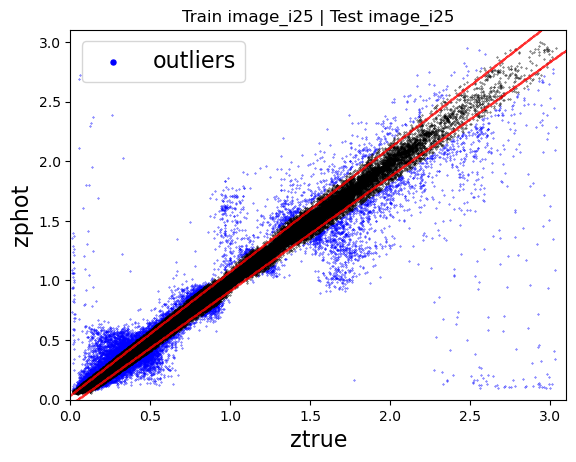

In [32]:
cutcriterion_all = np.maximum(0.06, 3*metrics.CalculateSigmaIQR())
mask = (np.fabs(ez) > np.fabs(cutcriterion_all))
points=np.linspace(0,3.3,1000)

plt.scatter(ztrue[mask],zphot[mask],s=0.1,color='blue')
plt.scatter([],[],color='blue',s=13,label='outliers')
plt.scatter(ztrue[~mask],zphot[~mask],s=0.1,color='black')
plt.scatter(points,points+3*metrics.CalculateSigmaIQR()*(1+points),color='red',s=0.1)
plt.scatter(points,points-3*metrics.CalculateSigmaIQR()*(1+points),color='red',s=0.1)
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.legend(fontsize=16,loc=2)
plt.xlabel('ztrue',fontsize=16)
plt.ylabel('zphot',fontsize=16)
plt.title(f'Train {name_train}_i{mag_train} | Test {name_test}_i{mag_test}')
#plt.savefig(f'/home/iago/ic_cosmo/plots/new_scatter_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')

Text(0.5, 1.0, 'train image test image')

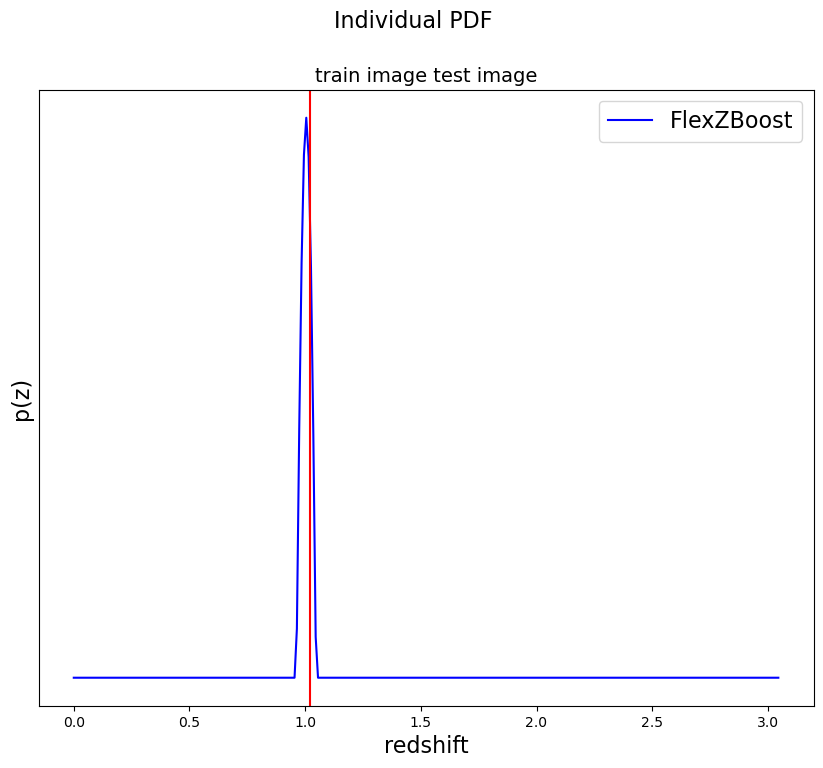

In [33]:
random_i = np.random.randint(0,len(zphot)) #len(zphot)-20000 
plt.figure(figsize=(10,8))
plt.plot(zgrid,pdfs[random_i],color='blue',label=f'FlexZBoost')
plt.axvline(ztrue[random_i],color='red')
plt.xticks([0,0.5,1,1.5,2.0,2.5,3.0])
plt.yticks([])
plt.xlabel('redshift',fontsize=16)
plt.ylabel('p(z)',fontsize=16)
plt.legend(fontsize=16)
plt.suptitle(f'Individual PDF',fontsize=16)
plt.title(f'train {name_train} test {name_test}',fontsize=14)
#plt.savefig(f'/home/iago/ic_cosmo/plots/pdf_z{int(ztrue[random_i])}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


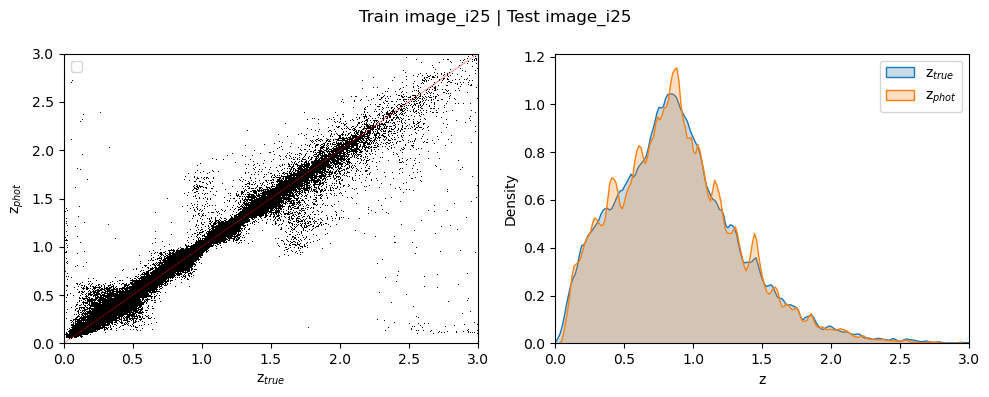

In [34]:

plot_old_valid(zphot,ztrue,f'Train {name_train}_i{mag_train} | Test {name_test}_i{mag_test}'
              )#,path_to_save=f'/home/iago/ic_cosmo/plots/scatter_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')


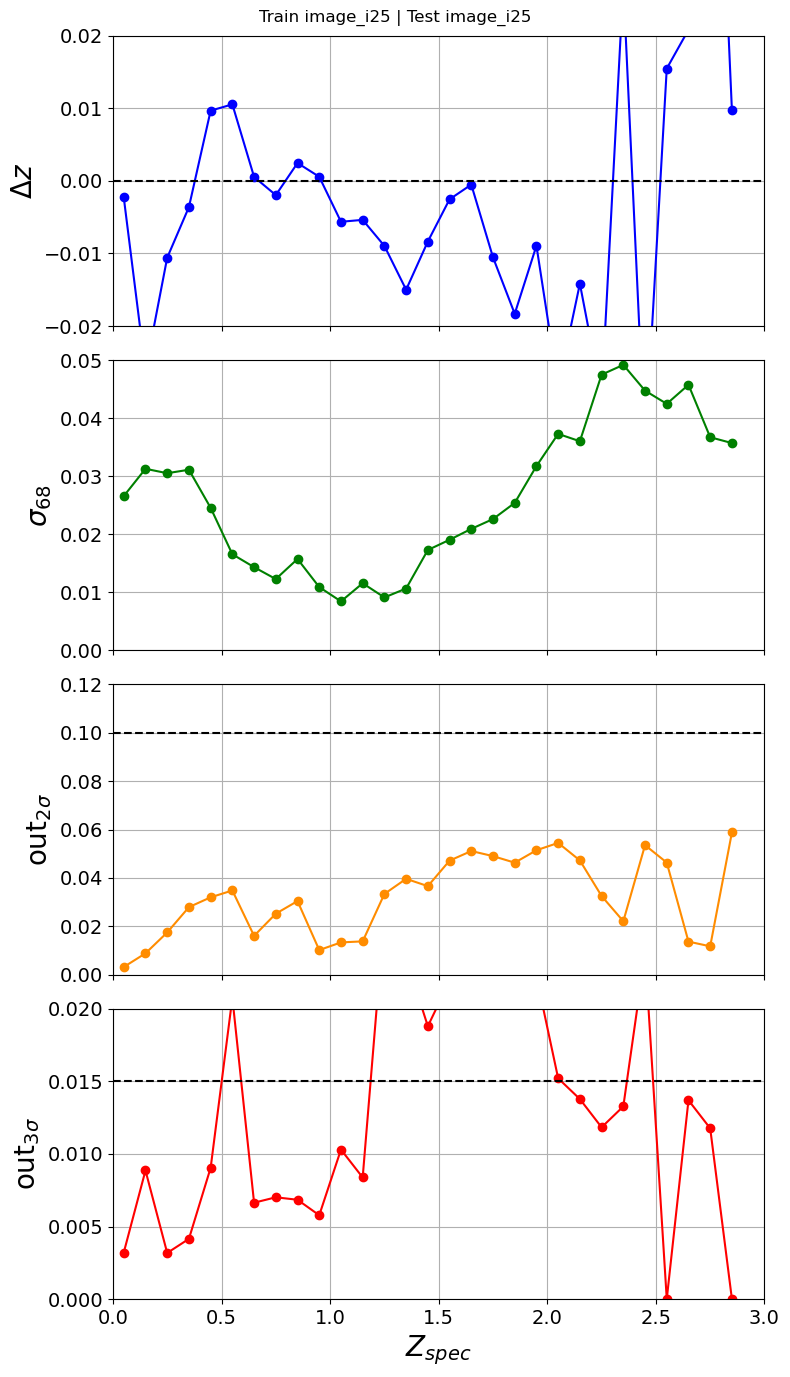

In [35]:

plot_metrics(ztrue,zphot,3,initial=0,title=f'Train {name_train}_i{mag_train} | Test {name_test}_i{mag_test}'
            )#,path_to_save=f'/home/iago/ic_cosmo/plots/metrics_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')


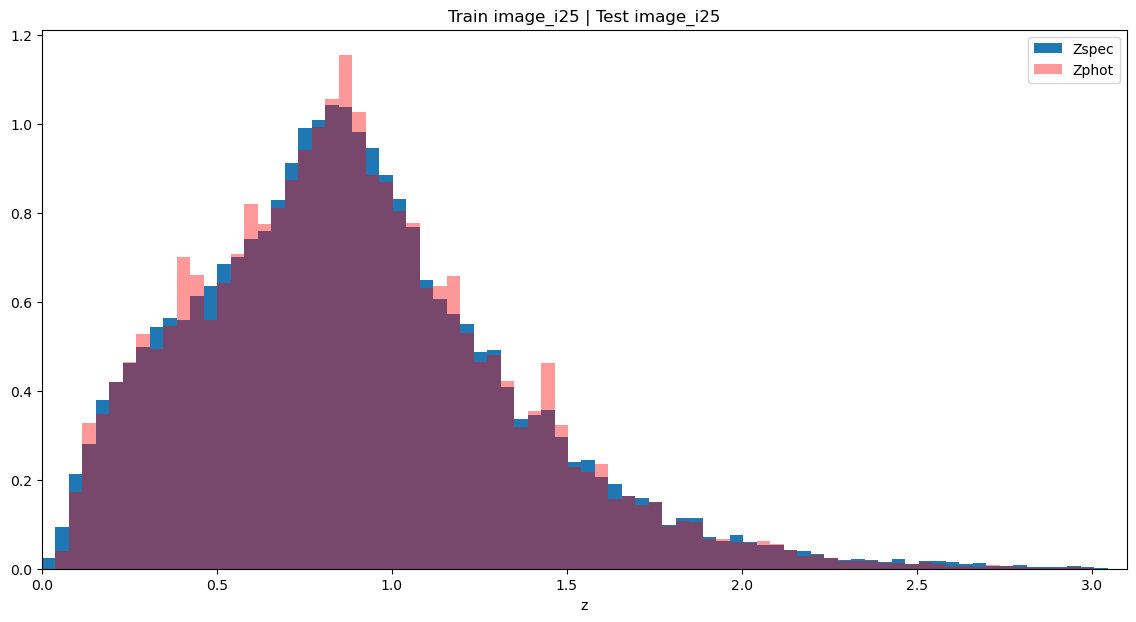

In [36]:
bins=np.linspace(0,z_max,80)
plt.figure(figsize=(14,7))
y = plt.hist(ztrue,bins=bins,label='Zspec', density=True)
t = plt.hist(zphot,bins=bins,label='Zphot', alpha=0.4, density=True,color='red')
#t = plt.hist(zphot_,bins=zgrid,label='Zphot_mixed', histtype = 'step', density=True)
plt.title(f'Train {name_train}_i{mag_train} | Test {name_test}_i{mag_test}')
plt.xlabel('z')
plt.xlim(0,3.1)
plt.legend()
#plt.savefig(f'/home/iago/ic_cosmo/plots/hist_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')

### For two results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


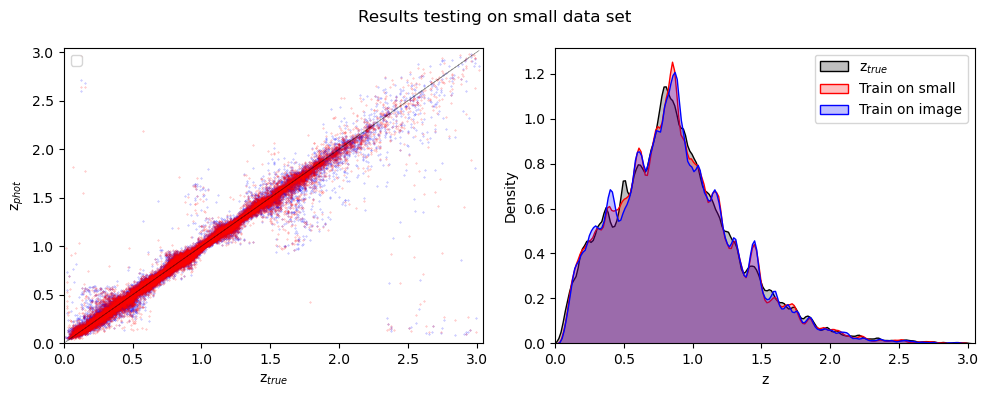

In [35]:
plot_old_valid_comparation(photoz1=zphot1,photoz=zphot2,title=f'Results testing on {name_test2} data set',photoz1name=f'Train on {name_train1}'
                           ,photozname=f'Train on {name_train2}',ztrue=ztrue
                          )#,path_to_save=f'/home/iago/ic_cosmo/plots/scatter_Fzb_Train{train1}_i{mag_train1} Test{test1}_i{mag_test1}')

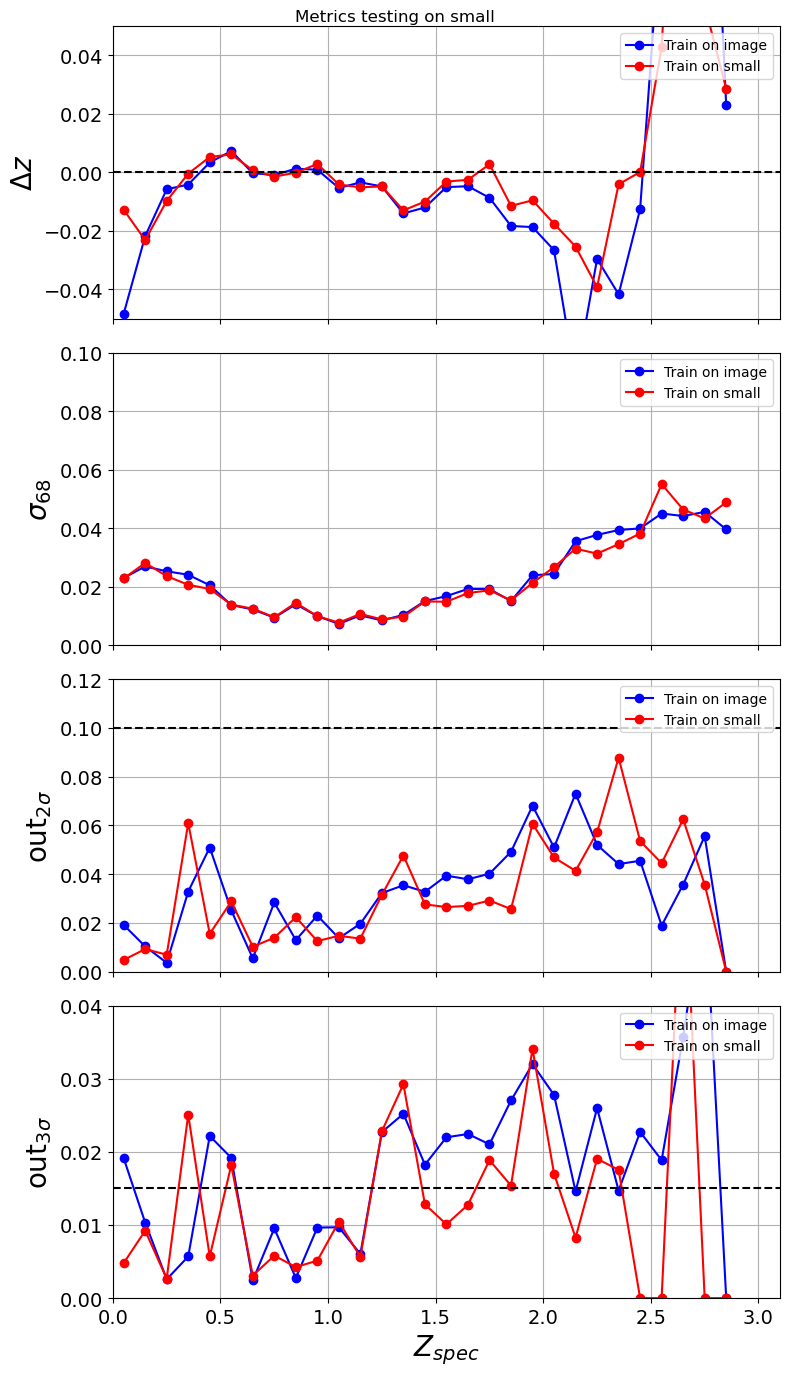

In [36]:
plot_metrics_comparation(ztrue,zphot1,zphot2,initial=0,maximum=3,name1=f'Train on {name_train1}',name2=f'Train on {name_train2}',title=f'Metrics testing on {name_test2}'
                        )#,path_to_save=f'/home/iago/ic_cosmo/plots/metrics_Fzb_Train{train1}_i{mag_train1} Test{test1}_i{mag_test1}')

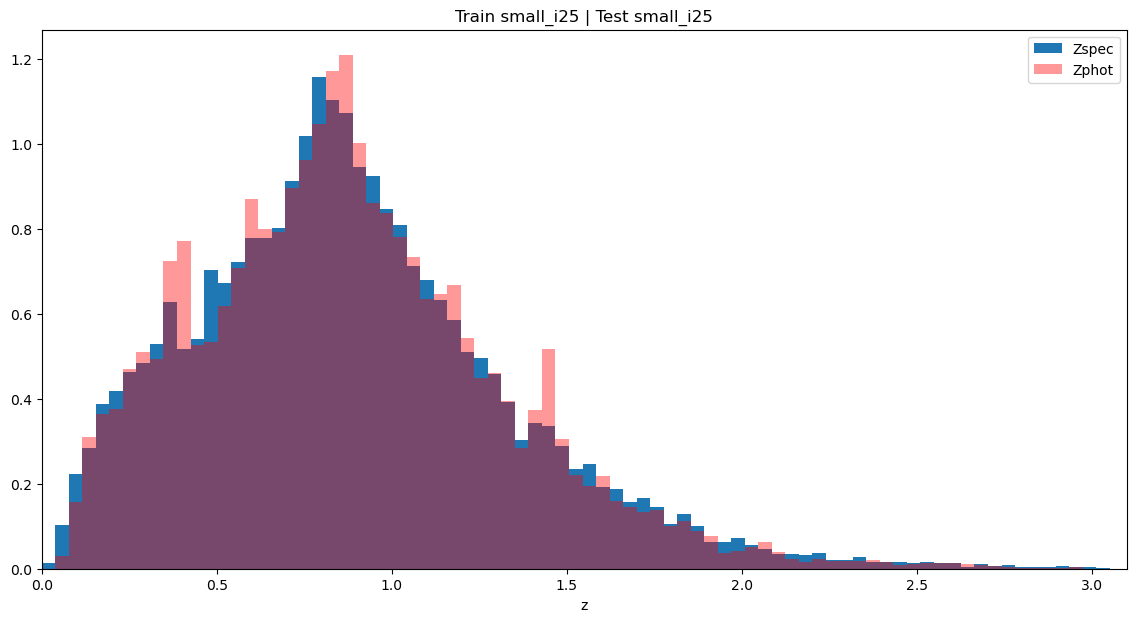

In [110]:
bins=np.linspace(0,z_max,80)
plt.figure(figsize=(14,7))
y = plt.hist(ztrue,bins=bins,label='Zspec', density=True)
t = plt.hist(zphot,bins=bins,label='Zphot', alpha=0.4, density=True,color='red')
#t = plt.hist(zphot_,bins=zgrid,label='Zphot_mixed', histtype = 'step', density=True)
plt.title(f'Train {name_train1}_i{mag_train1} | Test {name_test1}_i{mag_test1}')
plt.xlabel('z')
plt.xlim(0,3.1)
plt.legend()
#plt.savefig(f'/home/iago/ic_cosmo/plots/hist_Fzb_Train{train1}_i{mag_train1} Test{test1}_i{mag_test1}_u')

### Metrics for distributions

In [21]:
pitobj = PIT(result(), ztrue)
quant_ens = pitobj.pit
metamets = pitobj.calculate_pit_meta_metrics()
metamets

{'ad': Anderson_ksampResult(statistic=16057.942946079644, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001),
 'cvm': CramerVonMisesResult(statistic=2217.2629846320365, pvalue=3.589306136753123e-07),
 'ks': KstestResult(statistic=0.21265991882538027, pvalue=0.0, statistic_location=0.9785987420073974, statistic_sign=-1),
 'outlier_rate': 0.31736961765961097}

In [56]:
all_metrics['ad_pit']=[metamets['ad'].statistic]
all_metrics['cvm_pit']=[metamets['cvm'].statistic]
all_metrics['ks_pit']=[metamets['ks'].statistic]
all_metrics['out_pit']=[metamets['outlier_rate']]

In [24]:
cdelossobj = CDELoss(result.data, zgrid, ztrue)

In [57]:
cde_stat_and_pval = cdelossobj.evaluate()
print(f"CDE loss of this sample: {cde_stat_and_pval.statistic:.2f}") 
all_metrics['cde_loss']=[np.round(cde_stat_and_pval.statistic,2)]

CDE loss of this sample: -5.83


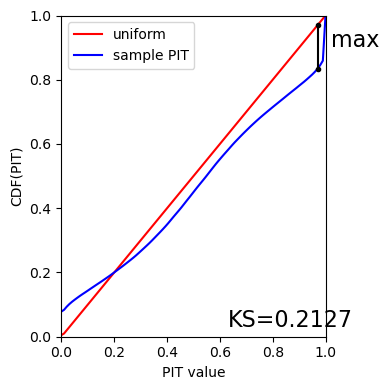

In [58]:
ks_plot(pitobj)

In [59]:
for line in all_metrics:
    all_metrics[line]=np.array(all_metrics[line][0])

In [60]:
df_all_metrics = pd.DataFrame(all_metrics,index=[0])
df_all_metrics['dataset']=f'{name_train}_i{mag_train} {name_test}_i{mag_test}'

In [61]:
#g = pd.DataFrame().to_csv('/home/iago/ic_cosmo/metrics',sep = ' ')     ######## if we want to reset the file

In [62]:
origin = pd.read_csv('/home/iago/ic_cosmo/metrics',sep =' ')
if np.round(np.array(origin['mean'])[-1],5) ==np.round(df_all_metrics['mean'][0],5):
    None
else:
    new = pd.concat([origin, df_all_metrics])
    new.to_csv('/home/iago/ic_cosmo/metrics',sep =' ',index=False)

In [26]:
origin = pd.read_csv('/home/iago/ic_cosmo/metrics',sep =' ')
origin

Unnamed: 0      mean  variance      skew      ad_n      ks_n     cvm_n  \
0         NaN  0.015409 -0.001332 -0.048525 -1.238186  0.019369  0.006835   
1         NaN  0.017914  0.001564 -0.029223 -1.200988  0.016755  0.004924   
2         NaN  0.013041  0.001914 -0.022803 -0.726678  0.056323  0.034367   
3         NaN  0.002691 -0.001322  0.009349 -0.961386  0.043389  0.011155   
4         NaN  0.019009  0.002076 -0.027331 -1.230084  0.013422  0.005090   
5         NaN  0.015354 -0.000617 -0.044202 -1.243463  0.015681  0.004661   
6         NaN -0.027247 -0.029782 -0.032998 -0.523383  0.055526  0.109787   

        rms      bias     f_out        ad_pit      cvm_pit    ks_pit  \
0  0.045803 -0.000085  0.029295   1097.928088    73.098527  0.053691   
1  0.041179 -0.000118  0.016724    229.205087    21.833888  0.041118   
2  0.019816  0.000095  0.003968     17.790849     1.273994  0.041342   
3  0.029098 -0.000084  0.008813    350.028778    28.382335  0.040594   
4  0.052936  0.000282  0.035187   1880.051009   137.823914  0.071151   
5  0.039107 -0.000344  0.018451    202.472401    28.000719  0.046299   
6  0.086724 -0.001806  0.050652  16057.942946  2217.262985  0.212660   

    out_pit  cde_loss               dataset  
0  0.093316    -10.35   image_i25 image_i25  
1  0.074060    -11.51   small_i25 small_i25  
2  0.074742    -17.78   small_i24 small_i24  
3  0.074865    -16.01   image_i24 image_i24  
4  0.120227     -9.36   small_i25 image_i25  
5  0.058695    -11.73   image_i25 small_i25  
6  0.317370     -5.83  image_i24 image_i255

In [58]:
metrics_subset = origin[['dataset','cde_loss','out_pit']]
metrics_subset['out_pit'] = np.round(metrics_subset['out_pit'],4)
metrics_subset['cde_loss'] = np.round(metrics_subset['cde_loss'],1)

In [59]:
metrics_subset.loc[len(metrics_subset.columns)] = ['DC1',-10.60,0.0202]

In [98]:
metrics_table(metrics_subset)

|Dataset |CDE Loss | Fraction PIT|
|:---|---:|---:|
|small_i24 small_i24           |  -17.8000 |    0.0747 |
|image_i25 small_i25           |  -11.7000 |    0.0587 |
|small_i25 small_i25           |  -11.5000 |    0.0741 |
|DC1           |  -10.6000 |    0.0202 |
|image_i25 image_i25           |  -10.4000 |    0.0933 |
|small_i25 image_i25           |   -9.4000 |    0.1202 |
|image_i24 image_i255           |   -5.8000 |    0.3174 |

In [ ]:
%%time
plot_pit_qq(pdfs,zgrid,ztrue,title=f'Fzb_Train{name_train}_i{mag_train} Test{name_test}_i{mag_test}')

In [143]:
origin

Unnamed: 0      mean  variance      skew      ad_n      ks_n     cvm_n  \
0         NaN  0.015409 -0.001332 -0.048525 -1.238186  0.019369  0.006835   
1         NaN  0.017914  0.001564 -0.029223 -1.200988  0.016755  0.004924   
2         NaN  0.013041  0.001914 -0.022803 -0.726678  0.056323  0.034367   
3         NaN  0.002691 -0.001322  0.009349 -0.961386  0.043389  0.011155   
4         NaN  0.019009  0.002076 -0.027331 -1.230084  0.013422  0.005090   
5         NaN  0.015354 -0.000617 -0.044202 -1.243463  0.015681  0.004661   
6         NaN -0.027247 -0.029782 -0.032998 -0.523383  0.055526  0.109787   

        rms      bias     f_out        ad_pit      cvm_pit    ks_pit  \
0  0.045803 -0.000085  0.029295   1097.928088    73.098527  0.053691   
1  0.041179 -0.000118  0.016724    229.205087    21.833888  0.041118   
2  0.019816  0.000095  0.003968     17.790849     1.273994  0.041342   
3  0.029098 -0.000084  0.008813    350.028778    28.382335  0.040594   
4  0.052936  0.000282  0.035187   1880.051009   137.823914  0.071151   
5  0.039107 -0.000344  0.018451    202.472401    28.000719  0.046299   
6  0.086724 -0.001806  0.050652  16057.942946  2217.262985  0.212660   

    out_pit  cde_loss               dataset  
0  0.093316    -10.35   image_i25 image_i25  
1  0.074060    -11.51   small_i25 small_i25  
2  0.074742    -17.78   small_i24 small_i24  
3  0.074865    -16.01   image_i24 image_i24  
4  0.120227     -9.36   small_i25 image_i25  
5  0.058695    -11.73   image_i25 small_i25  
6  0.317370     -5.83  image_i24 image_i255

In [ ]:
plot_all_metrics_pit(origin,'All metrics for PIT distribution'
                    )#,path_to_save=f'/home/iago/ic_cosmo/plots/all_metrics_pit')

In [ ]:
plot_all_metrics(origin,'Point metrics for all data sets'
                )#,path_to_save=f'/home/iago/ic_cosmo/plots/all_metrics_points')

In [ ]:
plot_all_metrics_n(origin,'All metrics for N(z) distribution'
                  )#,path_to_save=f'/home/iago/ic_cosmo/plots/all_metrics_nz')

In [ ]:
plot_all_moments(origin,'Three moments for all data sets'
                )#,path_to_save=f'/home/iago/ic_cosmo/plots/all_metrics_moments')

### Extra plots

In [79]:
catalog=french

In [76]:
catalog = french[french['mag_i_lsst']<24]
ztrue = catalog['redshift']

In [77]:
vm=[0.09,0.17,0.29,0.47,0.56,0.69]
va=[0.14,0.26,0.4,0.55,0.65,0.81]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


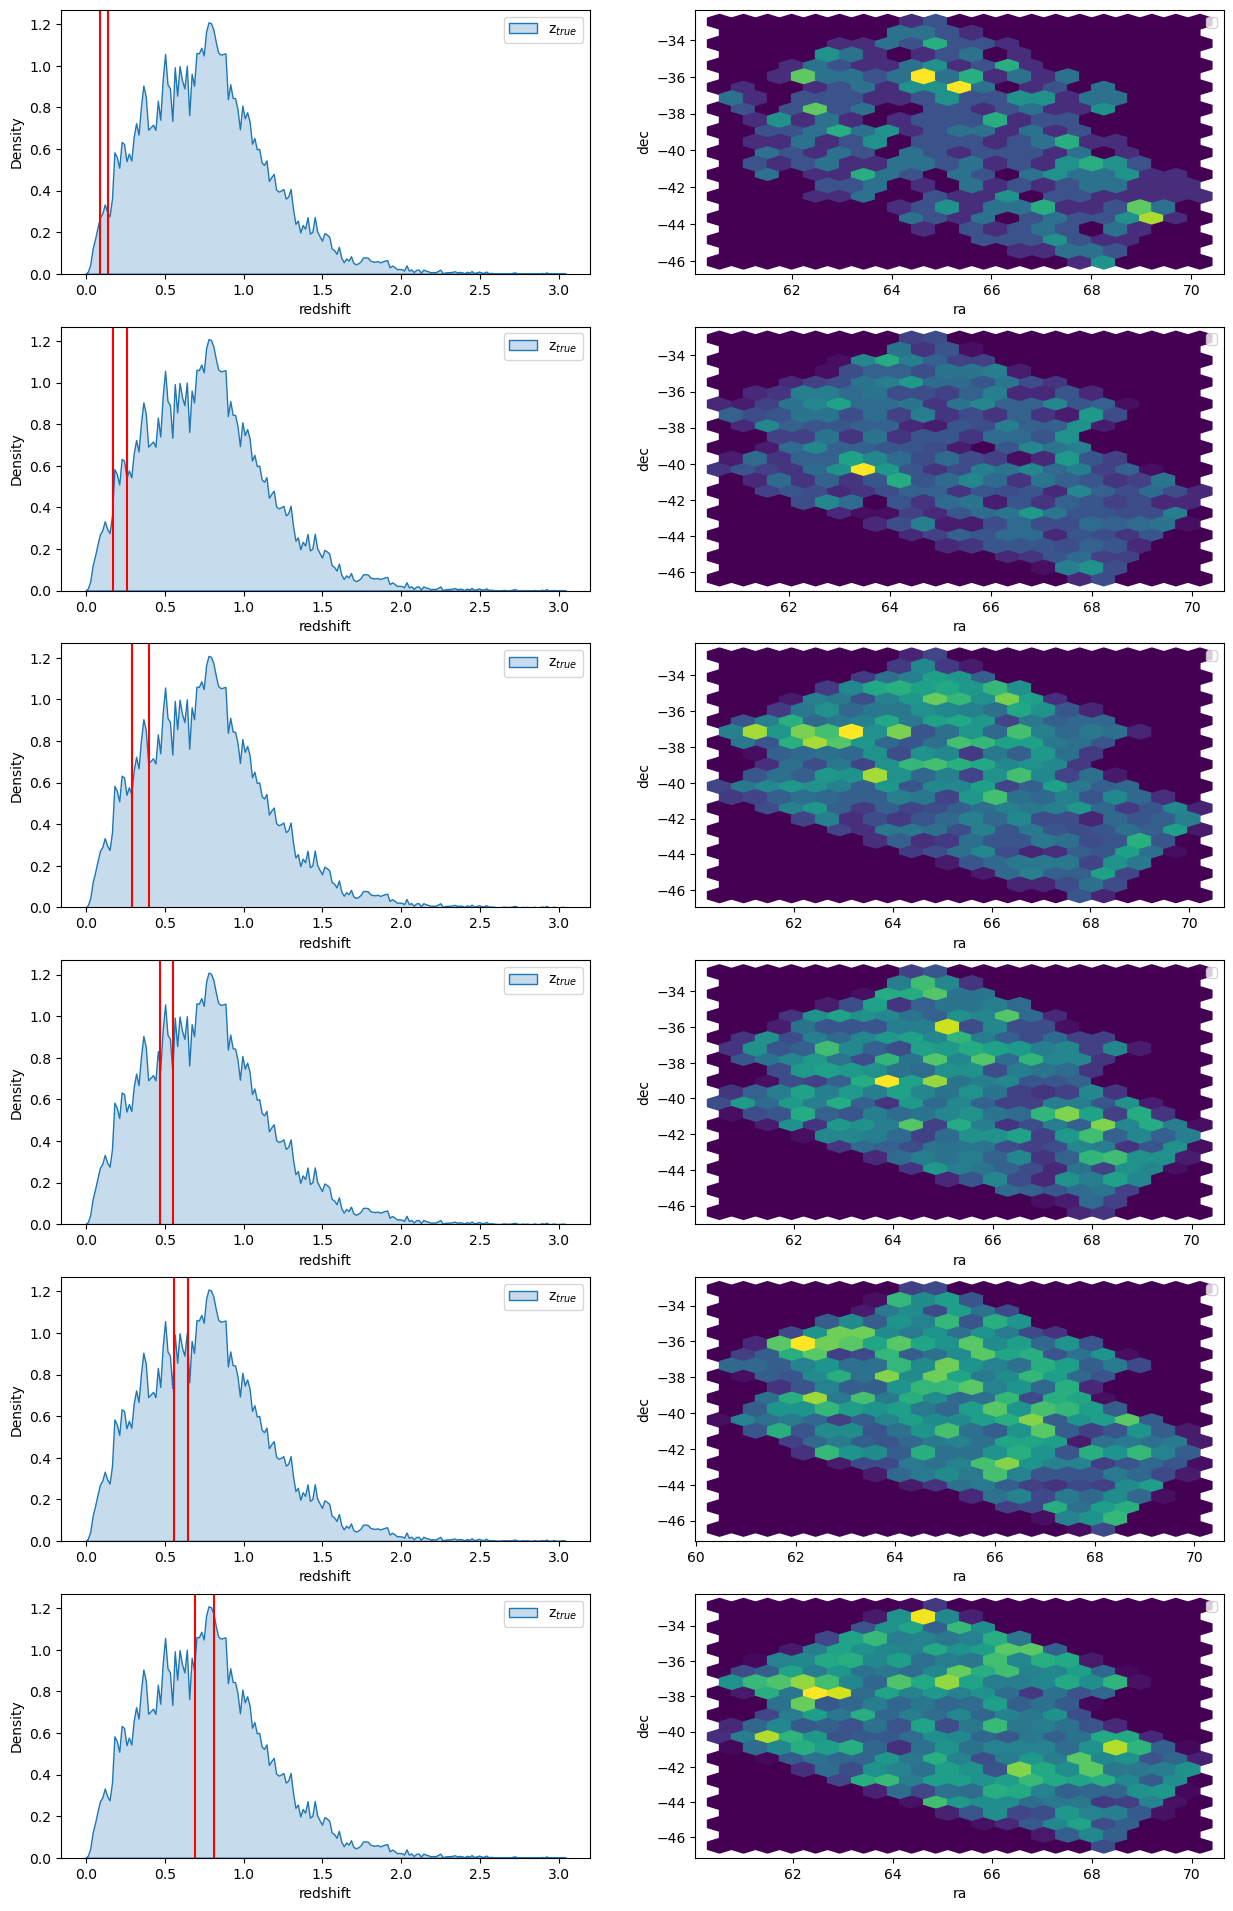

In [78]:
j=1
plt.figure(figsize=(15,24))

for i in range(len(vm)):


    plt.subplot(6,2,j)
    t = sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.1)
    plt.legend()
    plt.axvline(vm[i],color='red')
    plt.axvline(va[i],color='red')
    j+=1

    plt.subplot(6,2,j)
    part = catalog[(catalog['redshift']>vm[i])&(catalog['redshift']<va[i])]
    plt.hexbin(part['ra'],part['dec'],gridsize=20)
    #plt.scatter(catalog['ra'],catalog['dec'],color='blue',s=3,alpha=0.07)
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.legend()
    j+=1

#plt.savefig('/home/iago/ic_cosmo/plots/LSS_plot_hist.png')
plt.show()

In [40]:
catalog=french

Text(0.5, 1.0, 'Possible LSS in French data')

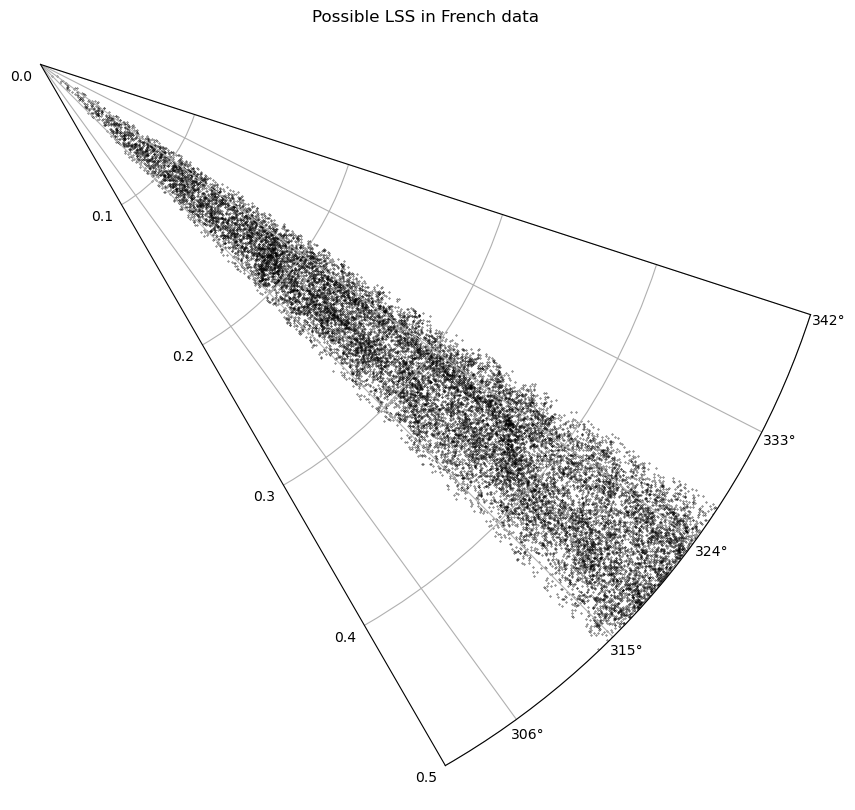

In [41]:
ra = catalog['ra']*np.pi/180
dec = catalog['dec']*np.pi/180

ztrue = catalog['redshift']

x = ztrue*np.cos((ra**2+dec**2)**0.5)
y = ztrue*np.sin((ra**2+dec**2)**0.5)

plt.figure(figsize=(10,10))
plt.subplot(111, polar=True)  # Criando um subplot polar
plt.scatter(dec, ztrue,s=0.09,color='black')
plt.xlim(np.pi*10/6,np.pi*19/10)
plt.ylim(0,0.5)
plt.title('Possible LSS in French data')

Text(0.5, 1.0, 'Possible LSS in French data')

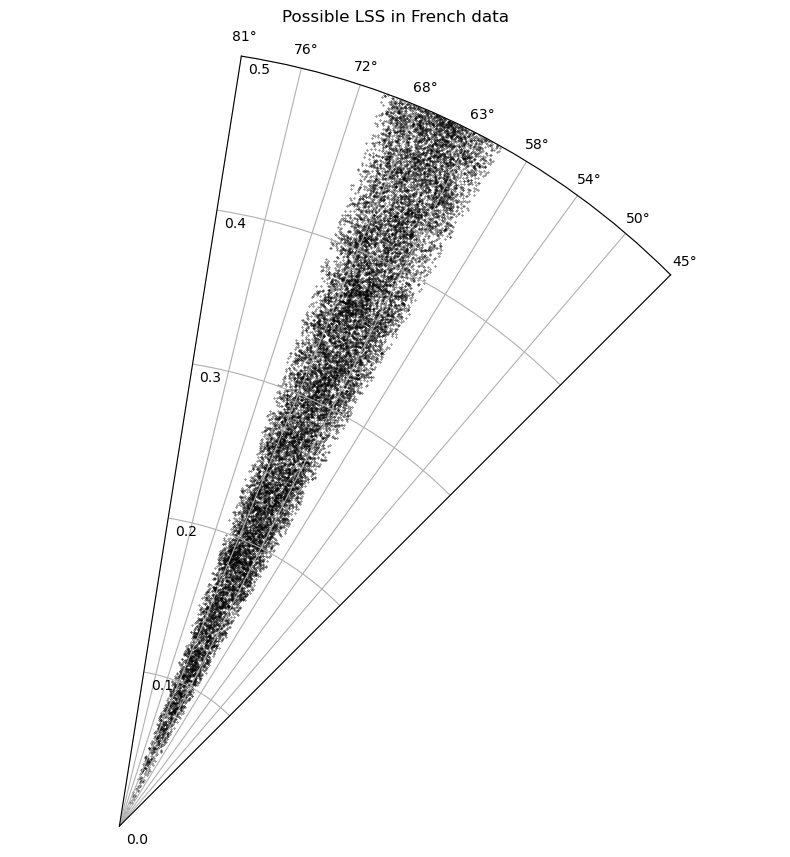

In [106]:
plt.figure(figsize=(10,10))
plt.subplot(111, polar=True)  # Criando um subplot polar
plt.scatter(ra, ztrue,s=0.09,color='black')
plt.xlim(np.pi*9/20,np.pi/4)
plt.ylim(0,0.5)
plt.title('Possible LSS in French data')

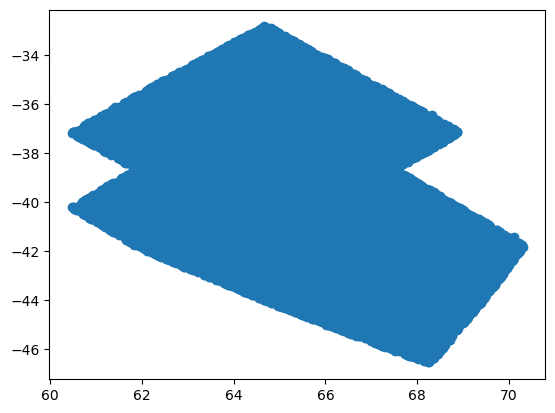

In [20]:
plt.scatter(catalog['ra'],catalog['dec')

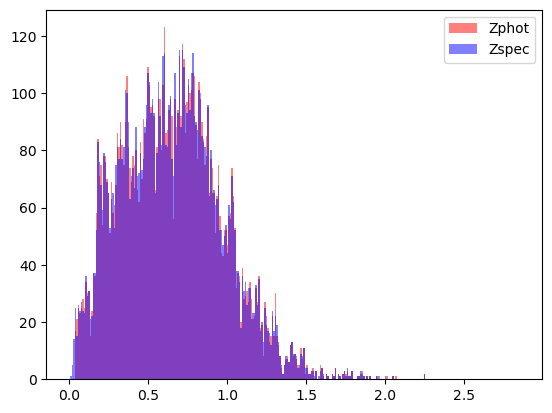

In [86]:
t = plt.hist(zphot,bins=zgrid,label='Zphot',alpha=0.5, color='red')
y = plt.hist(ztrue,bins=zgrid,label='Zspec',alpha=0.5, color='blue')
plt.legend()

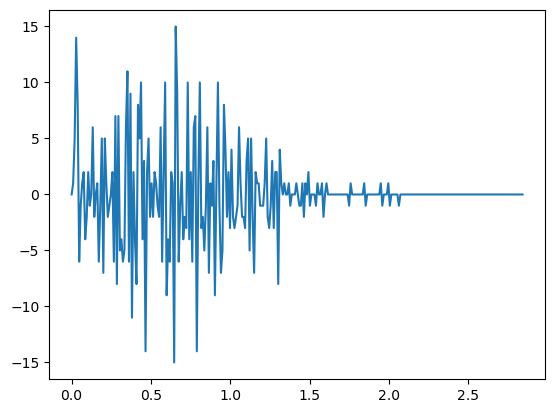

In [87]:
plt.plot(zgrid[:-1],y[0]-t[0])